# Classifying Fraud by Decision Trees


Table of Contents:
1. Importing the libraries and modules
2. Importing the data
3. Initial investigation the data
4. Reworking the data - missing values, dropping duplicates, etc.
5. Further investigation for insights - possible features
6. Splitting data into dependent and independent variables
7. Enoding the data
8. Build preliminary classification tree
9. Comparing Decision Trees, Random Forest, AdaBoost, and XGBoost
10. Comparing DT, RF, Ada, XGB with SMOTE
11. Tuning the hyperparameters of XGBoost
12. Building, evaluating, drawing, and interpretation of final classification model

**This is a work in progress. I am currently working through parts 8-11 and will need to add a new section on feature selection between part 8 and 9.**

# **PART 1 & 2:** Import libraries, modules and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pandasql import sqldf
# from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from tabulate import tabulate
from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import plot_importance

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import hyperopt.pyll
from hyperopt.pyll import scope
from hpsklearn import HyperoptEstimator

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.binary import BinaryEncoder
from category_encoders.one_hot import OneHotEncoder


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [2]:
df = pd.read_csv('../data/01_raw/fraud_oracle.csv')
print('The data constain ', len(df),' observations.')
df.head()

The data constain  15420  observations.


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


# **PART 3:** Initial Investigation on Data

In [3]:
print("#####################################################################################")
print("Shape of data: " + str(df.shape) )
print("#####################################################################################")
print("Missing values: ")
print((df.isnull().sum()))
print("#####################################################################################")
print(df.dtypes)
print("#####################################################################################")
print(df.describe().T)

#####################################################################################
Shape of data: (15420, 33)
#####################################################################################
Missing values: 
Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
Numb

In [4]:
# Unique values of each column
for col in df.columns:
    print(f'{col}: {len(df[col].unique())}-{df[col].unique()}\n')

Month: 12-['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Nov' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep']

WeekOfMonth: 5-[5 3 2 4 1]

DayOfWeek: 7-['Wednesday' 'Friday' 'Saturday' 'Monday' 'Tuesday' 'Sunday' 'Thursday']

Make: 19-['Honda' 'Toyota' 'Ford' 'Mazda' 'Chevrolet' 'Pontiac' 'Accura' 'Dodge'
 'Mercury' 'Jaguar' 'Nisson' 'VW' 'Saab' 'Saturn' 'Porche' 'BMW' 'Mecedes'
 'Ferrari' 'Lexus']

AccidentArea: 2-['Urban' 'Rural']

DayOfWeekClaimed: 8-['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday'
 '0']

MonthClaimed: 13-['Jan' 'Nov' 'Jul' 'Feb' 'Mar' 'Dec' 'Apr' 'Aug' 'May' 'Jun' 'Sep' 'Oct'
 '0']

WeekOfMonthClaimed: 5-[1 4 2 3 5]

Sex: 2-['Female' 'Male']

MaritalStatus: 4-['Single' 'Married' 'Widow' 'Divorced']

Age: 66-[21 34 47 65 27 20 36  0 30 42 71 52 28 61 38 41 32 40 63 31 45 60 39 55
 35 44 72 29 37 59 49 50 26 48 64 33 74 23 25 56 16 68 18 51 22 53 46 43
 57 54 69 67 19 78 77 75 80 58 73 24 76 62 79 70 17 66]

Fault: 2-['Policy Holder' 'Third Party']

PolicyType: 9-['Spor

# **Data Dictionary (at first glance)**
Results of printing the unique values from each feature. Things I noticed about each feature.
1. **Month** - object
    * contains 3 letter abbreviations for the months of the year 
    * Are these the months in which the accident occured?
2. **WeekOfMonth** - int64
    * provides the week in the month the accident occured?
3. **DayOfWeek** - object
    * contains days of the week - are these the days of the week the accident occured on?
4. **Make** - object
    * contains a list of 19 car manufacturers
5. **AccidentArea** - object
    * classifies area for accident as "Urban" or "Rural"
6. **DayOfWeekClaimed** - object
    * contains the day of the week the claim was filed
    * also contains '0' - need to check how many of these there are and see about "fixing" - missing data?
7. **MonthClaimed** - object
    * contains 3 letter abbreviations for the months of the year 
    * contains '0' - need to check how many there are and what they mean - missing data?
8. **WeekOfMonthClaimed** - int64
    * contains weeks in the month that the claimed in filed
9. **Sex** - object
    * gender of individual making claim?
    * binary data, convert to 1 or 0
10. **MaritalStatus** - object
    * marital status of individual making claim?
11. **Age** - int64
    * ages of individual making claim?
    * there is at least one individual with age 0 - missing data?
12. **Fault** - object
    * categorization of who was deemed at fault.
    * convert to binary, 1 or 0
13. **PolicyType** - object
    * contains two pieces of info - 
        * the type of insurance on the car - liability, all perils, collision
        * category of the vehicle - sport, sedan, utility
14. **VehicleCategory** - object
    * contains the categorization of the vehicle (see PolicyType)
15. **VehiclePrice** - object
    * contains ranges for the value of the vehicle
    * replace ranges with mean value of range and convert to float
16. **FraudFound_P** - int64
    * indicats whether the claim was fraudulant (1) or not (0)
    * **this is what we want to predict**
17. **PolicyNumber** - int64
    * the masked policy number, appears to be the same as row number minus 1
18. **RepNumber** - int64
    * rep number is  integer from 1 - 16
19. **Deductible** - int64
    * the deductible amount
    * integer values
20. **DriverRating** - int64
    * the scale is 1, 2, 3, 4
    * the name DriverRating implies the data is ordinal, but is it interval as well?
21. **Days_Policy_Accident** - object
    * as a guess, this is the number of days between when the policy was purchased and the accident occured
    * each value is again a range of values
    * change these to be mean of the range and make float
22. **Days_Policy_Claim** - object
    * another guess, this is the number of days that pass between the policy was purchased and the claim was filed
    * each value is a range
    * change these to be the mean of the ranges and make float
23. **PastNumberOfClaims** - object
    * previous number of claims filed by policy holder (or claimant?)
24. **AgeOfVehicle** - object
    * represents age of vehicle at time of the accident?
    * each value is a range of years
    * change these to be the mean of the ranges and make float
25. **AgeOfPolicyHolder** - object
    * each value is a range of ages"
    * change these to be the mean of the ranges and make float
26. **PoliceReportFiled** - object
    * indicates whether a police report was filed for the accident
    * convert to binary
27. **WitnessPresent** - object
    * indicted whether a witness was present
    * conver to binary
28. **AgentType** -  object
    * this classifies an agent who is handling the claim as internal vs external
    * what does this mean? 
    * change to binary
29. **NumberOfSuppliments** - object
    * probably not the number of vitamins taken daily
    * not sure what a suppliment is in insurance
30. **AddressChange_Claim** - object
    * guess, time from claim was filled to when person moved (i.e. filed an address change)
    * replace each interval with mean value of range
31. **NumberOfCars** - object
    * guess, number of cars involved in accident OR number of cars covered under policy
    * replace each interval with mean value of range
32. **Year** - int64
    * guess, year accident occured
33. **BasePolicy** - object
    * type of insurance coverage (see PolicyType)


# **Issues in data to investigate first**
* DayOfWeekClaimed - contains a 0 instead of a day of the week
* MonthClaimed - contains a 0 instead of the month
* Age - contains a 0 instead of the necessary age
* PolicyType - appears to be a concatenation of VehicleCategory and BasePolicy
* PolicyNumber - determine if they are the same as the row number minus 1

# **Thoughts/questions to look into**
* Are representatives fixed to a specific geographic region? 
    * i.e. will rep 1 always be rural vs urban?
* Are they fixed as always being internal or external?
    * i.e. would rep 1 always be considered internal vs external?
* Should 'Age' always fall in the range of 'AgeOfPolicyHolder'?
* PolicyType appears to contain the same information as VehicleCategroy and BasePolicy
    * Should they match? Do they always match?
    * Can we eliminate one or two of these features?
* Is a driver rated as 1 better or worse of a driver rated as a 4? Or is it a measure of Risk? Meaning a driver rated at 1 is at a higher risk of an accident than driver rated at 4?
* Are certain Months/Days of the week more prone to accidents than others?


In [5]:
# Which columns are categoric;
cat_col = [col for col in df.columns if df[col].dtypes == "O"]
cat_col

['Month',
 'DayOfWeek',
 'Make',
 'AccidentArea',
 'DayOfWeekClaimed',
 'MonthClaimed',
 'Sex',
 'MaritalStatus',
 'Fault',
 'PolicyType',
 'VehicleCategory',
 'VehiclePrice',
 'Days_Policy_Accident',
 'Days_Policy_Claim',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'AgeOfPolicyHolder',
 'PoliceReportFiled',
 'WitnessPresent',
 'AgentType',
 'NumberOfSuppliments',
 'AddressChange_Claim',
 'NumberOfCars',
 'BasePolicy']

# **PART 4:** Reworking the data - missing values, dropping duplicates, etc.



First, we will look into the 'PolicyNumber'. As mentioned above, I suspect that the 'PolicyNumber' is simply the row number minus 1. I check this by summing the policy numbers, and then using the summation identity: sum(i)(for i to n) = n(n+1)/2, where I take n to be the number of rows. If they come out the same then there are no missing or duplicate PolicyNumbers.

In [6]:
print(df['PolicyNumber'].sum())
print((len(df['PolicyNumber'])*(len(df['PolicyNumber']) +1 ))/2 )
df['PolicyNumber']

118895910
118895910.0


0            1
1            2
2            3
3            4
4            5
         ...  
15415    15416
15416    15417
15417    15418
15418    15419
15419    15420
Name: PolicyNumber, Length: 15420, dtype: int64

We now take care of the 0 in the 'MonthClaimed' and 'DayOfWeekClaimed' features, then we tackle the 'Age' of 0 problem.

In [7]:
#Investigate the 0 in DayOfWeekClaimed and MonthClaimed
print('DayOfWeekClaimed has ', len(df.loc[(df['DayOfWeekClaimed']=='0')]), ' row(s) with a 0')
print('MonthClaimed has ',len(df.loc[(df['MonthClaimed']=='0')]),' row(s) with a 0') 
print(' ')

#We see there is only one row where either the DayOfWeekClaimed or MonthClaimed are 0. 
#So now we compare them.
print(df.loc[(df['DayOfWeekClaimed']=='0')])
print(df.loc[(df['MonthClaimed']=='0')])

# Both are zero in the same row (row 1516). 

DayOfWeekClaimed has  1  row(s) with a 0
MonthClaimed has  1  row(s) with a 0
 
     Month  WeekOfMonth DayOfWeek   Make AccidentArea DayOfWeekClaimed  \
1516   Jul            2    Monday  Honda        Rural                0   

     MonthClaimed  WeekOfMonthClaimed   Sex MaritalStatus  ...  AgeOfVehicle  \
1516            0                   1  Male        Single  ...           new   

     AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
1516          16 to 17                No             No  External   

      NumberOfSuppliments  AddressChange_Claim  NumberOfCars  Year  BasePolicy  
1516                 none            no change     1 vehicle  1994  All Perils  

[1 rows x 33 columns]
     Month  WeekOfMonth DayOfWeek   Make AccidentArea DayOfWeekClaimed  \
1516   Jul            2    Monday  Honda        Rural                0   

     MonthClaimed  WeekOfMonthClaimed   Sex MaritalStatus  ...  AgeOfVehicle  \
1516            0                   1  Male        Single

In [8]:
#Since both DayOfWeekClaimed and MonthClaimed are 0 for the same entry, I will drop
df2 = df.loc[df['DayOfWeekClaimed']!='0']

We have handled the 0 in the 'DayOfWeekClaimed' and 'MonthClaimed', next we need to investigate the 'Age' of 0.

In [9]:
#Resets the index on our new dataframe, df2, so we can iterate through the rows
#If we didn't do this, attempting to access df2.loc[1516] would throw a keyerror
#This suggests that df2 does not have a row 1516, which is just plain silly
df2.reset_index(drop=True, inplace=True)
len(df2)

15419

In [10]:
#There are 319 rows where the feature Age is assigned a zero, 
print(len(df2[df2['Age']==0]))

#though for the displayed rows the policy holder is said to be between 16 and 17 years old. 
df2.loc[df2['Age']==0, 'AgeOfPolicyHolder']

#Need to check the policy holders age and then reassign a value.
df2_age0_idx = (df2['Age']==0)


319


In [11]:
#confirms that every row with Age=0, has a Policy Holder that is aged between 16 and 17 years.
df2.loc[(df2['Age']==0),'AgeOfPolicyHolder'].unique()

array(['16 to 17'], dtype=object)

We could assign a value to 'Age' in one of the following ways
1. We could assign based on the lowest value in the range
2. We could assign based on the highest value in the range
3. We could assign based on the mean value in the range
4. We could drop all of those rows

To make this decision I felt it would best to investigate the relationship between 'Age' and 'AgeOfPolicyHolder' first. (Though my initial instinct is to replace with the mean of the range.

In [12]:
#splits the AgeOfPolicyHolder column into substrings so we
#can check that the age variable is in range for policyholder

groupings = []
for holder in df2['AgeOfPolicyHolder']:
    if 'to' in holder :
        temp = holder.split()
        nr=[int(temp[0]),int(temp[2])]
        groupings.append(nr)
    else :
        temp = holder.split()
        nr = [int(temp[1]),129]
        groupings.append(nr)
                        

In [13]:
#does the comparision of value for age to the value of the AgeOfPolicyHolder
age_idx = []
rw_idx = []
for r in range(len(df2['Age'])):
    if (df2.loc[r,'Age']>= groupings[r][0]) & (df2.loc[r,'Age']<= groupings[r][1]):
        age_idx.append(0)
    else:
        age_idx.append(1)
        rw_idx.append(r)

In [14]:
print(len(df2.loc[list(rw_idx),('Age','AgeOfPolicyHolder')]))
df2.loc[list(rw_idx),('Age','AgeOfPolicyHolder')]

7241


,Age,AgeOfPolicyHolder
0,21,26 to 30
4,27,31 to 35
5,20,21 to 25
7,0,16 to 17
8,30,31 to 35
...,...,...
15410,42,36 to 40
15411,28,31 to 35
15415,30,31 to 35
15416,24,26 to 30


During our investigation of the feature 'Age' being set to 0, we have established that there are 7241 rows out 15419, which is roughly 46.96% of the data, who's 'Age' does not correspond to the age range for 'AgeOfPolicyHolder'. A discrepancy this prevalent feels unlikely to be a typo. A somewhat reasonable assumption, is that the individual driving at the time of the accident was not the policy holder, but another individual.

This doesn't give us any clear indication on the direction to go. Therefore I will opt to replace the 0 with the mean value of the interval.

In [15]:
#Assigns an age of 16 to all rows with missing Age values
df2.loc[list(df2_age0_idx),'Age']=16.5

/tmp/ipykernel_15768/820980807.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[list(df2_age0_idx),'Age']=16.5


In [16]:
#Confirms that there are no Ages equal to 0.
print(df2['Age'].unique()==0)
len(df2[df2['Age']==0])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


0

Next we are going to check if there are any duplicate rows.

In [17]:
#Since the length of the df2 is the same as the df2.drop_duplicates, this tells us
#there are no duplicate rows
print(len(df2.drop_duplicates())==len(df2))

True


# **PART 5:** Further investigation for insights - possible features

The goal here is to gather some insight into the relationship between our observations and the desired predicted feature, 'FraudFound_P'.

In [18]:
df2_chi_result=[]
for feat in df2.columns:
    chi2_val, p_val, dof2, ex1 = stats.chi2_contingency(pd.crosstab(df2[feat], df2['FraudFound_P']))
    df2_chi_result.append([feat,chi2_val,p_val])
    
chi_df = pd.DataFrame(df2_chi_result, columns=['Features', 'Chi2 val', 'p-val'])
chi_df.sort_values(by='p-val',ascending=True, inplace=True)    
#Printing on the variables that had a p-val less than 0.05
print(tabulate(chi_df[chi_df['p-val']<0.05], headers=['Feature', 'Chi2 val', 'p-val']))

    Feature                  Chi2 val        p-val
--  --------------------  -----------  -----------
15  FraudFound_P          15401.2      0
12  PolicyType              437.491    1.76844e-89
32  BasePolicy              402.947    3.17044e-88
13  VehicleCategory         290.981    6.52082e-64
11  Fault                   264.985    1.40618e-59
29  AddressChange_Claim     104.723    9.70472e-22
18  Deductible               72.4063   1.30283e-15
14  VehiclePrice             67.8361   2.88832e-13
22  PastNumberOfClaims       53.5418   1.4052e-11
 3  Make                     59.8153   2.19157e-06
 6  MonthClaimed             42.2005   1.49524e-05
 4  AccidentArea             16.9019   3.9363e-05
24  AgeOfPolicyHolder        33.1049   5.89656e-05
 8  Sex                      13.4957   0.000239114
28  NumberOfSuppliments      18.1555   0.000408528
10  Age                     109.665    0.000447208
 0  Month                    29.7715   0.0017209
23  AgeOfVehicle             21.9951   0.0025

,PolicyType,FraudFound_P,Total Accidents,Percentage by PolicyType,Percentage by Total
0,Sedan - All Perils,411,4086,10.059,2.666
1,Sedan - Collision,384,5584,6.877,2.49
2,Sedan - Liability,36,4987,0.722,0.233
3,Sport - All Perils,0,22,0.0,0.0
4,Sport - Collision,48,348,13.793,0.311
5,Sport - Liability,0,1,0.0,0.0
6,Utility - All Perils,41,340,12.059,0.266
7,Utility - Collision,3,30,10.0,0.019
8,Utility - Liability,0,21,0.0,0.0
9,Column total,923,15419,53.51,5.985


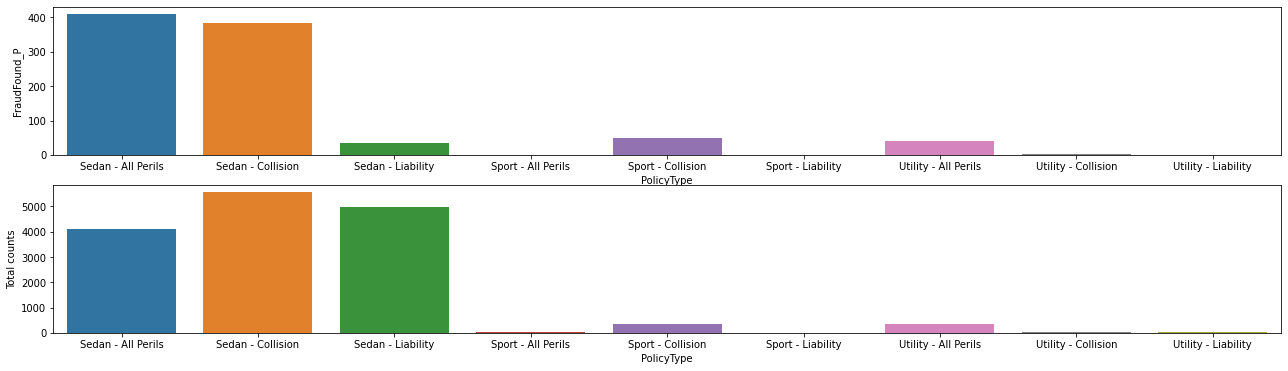

In [19]:
#plotting by FraudFound, looking to see if there are anything obvious that correlates to fraud
gpd_val1=df2.groupby('PolicyType').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val2=df2.groupby('PolicyType').agg('count').reset_index()

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(22, 6))
sns.barplot(x='PolicyType', y='FraudFound_P', data = gpd_val1, ax=ax1)
sns.barplot(x='PolicyType', y='FraudFound_P', data=gpd_val2, ax=ax2)

ax2.set(ylabel='Total counts')

None

total_list = pd.concat([gpd_val1, gpd_val2['FraudFound_P'].rename('Total Accidents')],axis=1)
total_list['Percentage by PolicyType']= round((total_list['FraudFound_P']/total_list['Total Accidents'])*100,3)
total_list['Percentage by Total'] = round((total_list['FraudFound_P']/sum(total_list['Total Accidents']))*100,3)

ax2.set(ylabel='Total counts')

data = [['Column total'],
        [sum(total_list['FraudFound_P'])], 
        [sum(total_list['Total Accidents'])], 
        [sum(total_list['Percentage by PolicyType'])], 
        [sum(total_list['Percentage by Total'])]]

nr = pd.DataFrame(data)

nr1 = nr.transpose()
nr1.rename(columns={0:'PolicyType',1:'FraudFound_P',2:'Total Accidents',3:'Percentage by PolicyType',4:'Percentage by Total'}, inplace=True)
pd.concat([total_list,nr1],ignore_index=True)


    VehicleCategory      FraudFound_P    Total Accidents    Percentage by VehicleCategory    Percentage by Total
--  -----------------  --------------  -----------------  -------------------------------  ---------------------
 0  Sedan                         795               9670                            8.221                  5.156
 1  Sport                          84               5358                            1.568                  0.545
 2  Utility                        44                391                           11.253                  0.285
 3  Column total                  923              15419                           21.042                  5.986
 
    BasePolicy      FraudFound_P    Total Accidents    Percentage by BasePolicy    Percentage by Total
--  ------------  --------------  -----------------  --------------------------  ---------------------
 0  All Perils               452               4448                      10.162                  2.931
 1  Collisi

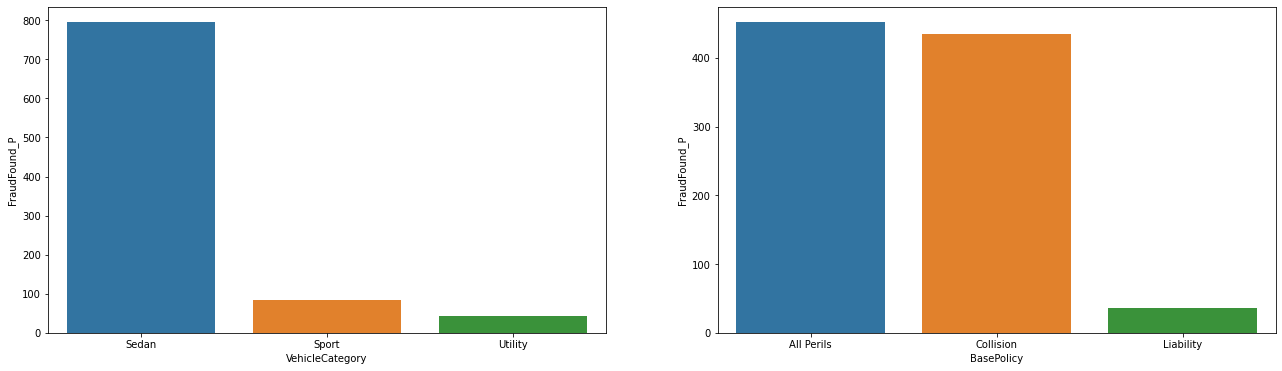

In [20]:
#plotting by FraudFound, looking to see if there are anything obvious that correlates to fraud
gpd_val1=df2.groupby('VehicleCategory').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val6=df2.groupby('VehicleCategory').agg('count').reset_index()
gpd_val3=df2.groupby('BasePolicy').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val7=df2.groupby('BasePolicy').agg('count').reset_index()

fig, (ax1, ax3) = plt.subplots(1,2,figsize=(22, 6))
sns.barplot(x='VehicleCategory', y='FraudFound_P', data = gpd_val1, ax=ax1)
#sns.barplot(x='VehicleCategory', y='FraudFound_P', data = gpd_val2, ax=ax2)
sns.barplot(x='BasePolicy', y='FraudFound_P', data = gpd_val3, ax=ax3)
#sns.barplot(x='BasePolicy', y='FraudFound_P', data = gpd_val4, ax=ax4)
None


total_list1 = pd.concat([gpd_val1, gpd_val6['FraudFound_P'].rename('Total Accidents')],axis=1)
total_list1['Percentage by VehicleCategory']= round((total_list1['FraudFound_P']/total_list1['Total Accidents'])*100,3)
total_list1['Percentage by Total'] = round((total_list1['FraudFound_P']/sum(total_list1['Total Accidents']))*100,3)

total_list2 = pd.concat([gpd_val3, gpd_val7['FraudFound_P'].rename('Total Accidents')],axis=1)
total_list2['Percentage by BasePolicy']= round((total_list2['FraudFound_P']/total_list2['Total Accidents'])*100,3)
total_list2['Percentage by Total'] = round((total_list2['FraudFound_P']/sum(total_list2['Total Accidents']))*100,3)

data1 = [['Column total'],
        [sum(total_list1['FraudFound_P'])], 
        [sum(total_list1['Total Accidents'])], 
        [sum(total_list1['Percentage by VehicleCategory'])], 
        [sum(total_list1['Percentage by Total'])]]

data2 = [['Column total'],
        [sum(total_list2['FraudFound_P'])], 
        [sum(total_list2['Total Accidents'])], 
        [sum(total_list2['Percentage by BasePolicy'])], 
        [sum(total_list2['Percentage by Total'])]]

nr1 = pd.DataFrame(data1)
nr1 = nr1.transpose()
nr1.rename(columns={0:'VehicleCategory',1:'FraudFound_P',2:'Total Accidents',3:'Percentage by VehicleCategory',4:'Percentage by Total'}, inplace=True)
tl1=pd.concat([total_list1,nr1],ignore_index=True)

nr2 = pd.DataFrame(data2)
nr2 = nr2.transpose()
nr2.rename(columns={0:'BasePolicy',1:'FraudFound_P',2:'Total Accidents',3:'Percentage by BasePolicy',4:'Percentage by Total'}, inplace=True)
tl2=pd.concat([total_list2,nr2],ignore_index=True)

print(tabulate(tl1, headers=tl1.columns))
print(' ')
print(tabulate(tl2, headers=tl2.columns))



    Fault            FraudFound_P    Total Accidents    Percentage by Fault    Percentage by Total
--  -------------  --------------  -----------------  ---------------------  ---------------------
 0  Policy Holder             886              11229                  7.89                   5.746
 1  Third Party                37               4190                  0.883                  0.24
 2  Column total              923              15419                  8.773                  5.986
 
    Deductible      FraudFound_P    Total Accidents    Percentage by Deductible    Percentage by Total
--  ------------  --------------  -----------------  --------------------------  ---------------------
 0  300                        2                  8                      25                      0.013
 1  400                      856              14837                       5.769                  5.552
 2  500                       47                263                      17.871             

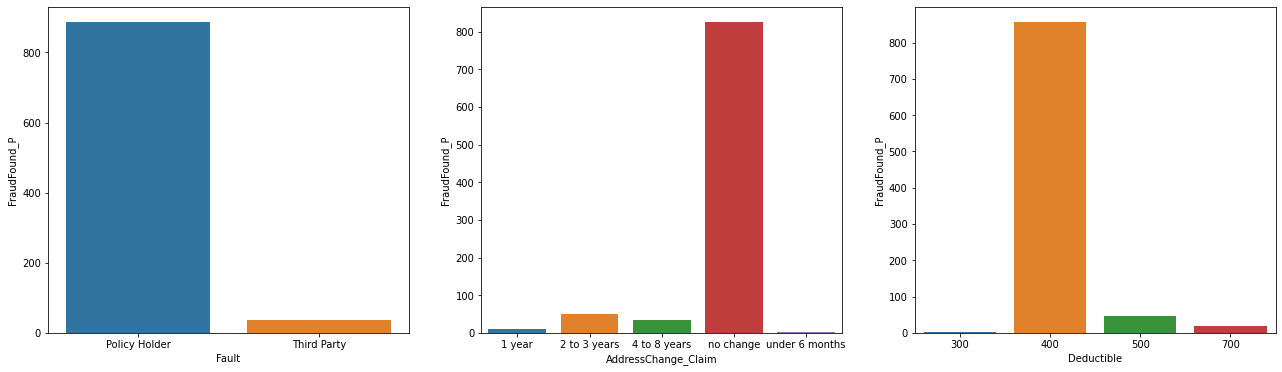

In [21]:
#plotting by FraudFound, looking to see if there are anything obvious that correlates to fraud
gpd_val1=df2.groupby('Fault').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val2=df2.groupby('Deductible').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val3=df2.groupby('AddressChange_Claim').agg({'FraudFound_P':'sum'}).reset_index()

gpd_valc1=df2.groupby('Fault').agg('count').reset_index()
gpd_valc2=df2.groupby('Deductible').agg('count').reset_index()
gpd_valc3=df2.groupby('AddressChange_Claim').agg('count').reset_index()

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22, 6))
sns.barplot(x='Fault', y='FraudFound_P', data = gpd_val1, ax=ax1)
sns.barplot(x='Deductible', y='FraudFound_P', data = gpd_val2, ax=ax3)
sns.barplot(x='AddressChange_Claim', y='FraudFound_P', data = gpd_val3, ax=ax2)

part_list=[gpd_val1, gpd_val2, gpd_val3]
counts_lst=[gpd_valc1,gpd_valc2,gpd_valc3]
srch_gp=['Fault','Deductible','AddressChange_Claim']
total_list=[]
for i in range(len(counts_lst)):
    temp1 = counts_lst[i]
    gby=srch_gp[i]
    temp2=  pd.concat([part_list[i], temp1['FraudFound_P'].rename('Total Accidents')],axis=1) 
    temp2['Percentage by {}'.format(gby)]= round((temp2['FraudFound_P']/temp2['Total Accidents'])*100,3)
    temp2['Percentage by Total'] = round((temp2['FraudFound_P']/sum(temp2['Total Accidents']))*100,3)
    
    temp3 = [['Column total'],
        [sum(temp2['FraudFound_P'])], 
        [sum(temp2['Total Accidents'])], 
        [sum(temp2['Percentage by {}'.format(gby)])], 
        [sum(temp2['Percentage by Total'])]]

    nr1 = pd.DataFrame(temp3)
    nr1 = nr1.transpose()
    nr1.rename(columns={0:'{}'.format(gby),1:'FraudFound_P',2:'Total Accidents',3:'Percentage by {}'.format(gby),4:'Percentage by Total'}, inplace=True)
    total_list.append(pd.concat([temp2,nr1],ignore_index=True))

for ii in range(len(total_list)):
    print(tabulate(total_list[ii], headers=total_list[ii].columns))
    print(' ')

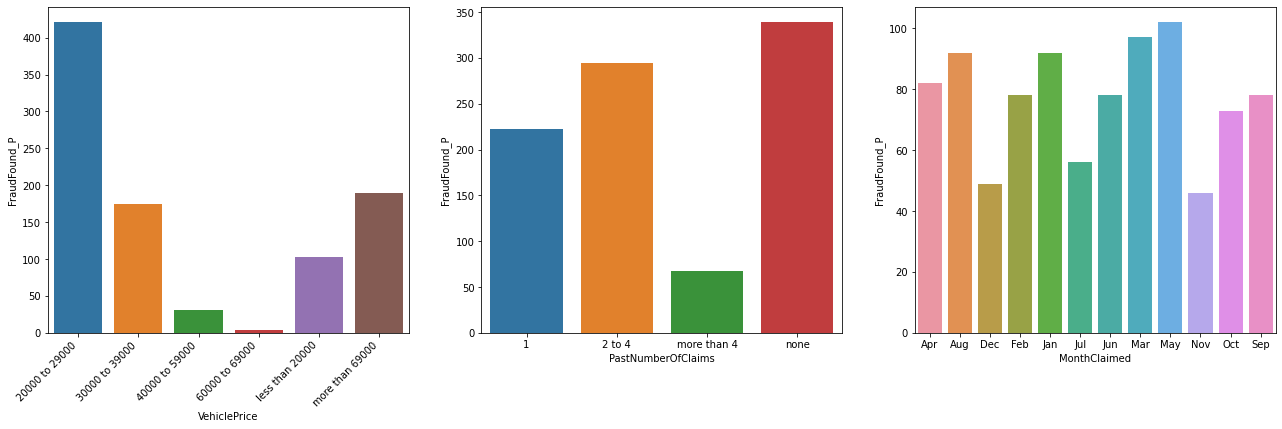

In [22]:
#VehiclePrice, PastNumberOfClaims, MonthCalimed
gpd_val1=df2.groupby('VehiclePrice').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val2=df2.groupby('PastNumberOfClaims').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val3=df2.groupby('MonthClaimed').agg({'FraudFound_P':'sum'}).reset_index()


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22, 6))
grph1=sns.barplot(x='VehiclePrice', y='FraudFound_P', data = gpd_val1, ax=ax1)
sns.barplot(x='PastNumberOfClaims', y='FraudFound_P', data = gpd_val2, ax=ax2)
sns.barplot(x='MonthClaimed', y='FraudFound_P', data = gpd_val3, ax=ax3)

grph1.set_xticklabels(grph1.get_xticklabels(),
                    rotation=45,
                    horizontalalignment='right'
                    )
None

,Make,FraudFound_P,Total Accidents,Percentage by Make,Percentage by Total
0,Accura,59,472,12.5,0.383
1,BMW,1,15,6.667,0.006
2,Chevrolet,94,1681,5.592,0.61
3,Dodge,2,109,1.835,0.013
4,Ferrari,0,2,0.0,0.0
5,Ford,33,450,7.333,0.214
6,Honda,179,2800,6.393,1.161
7,Jaguar,0,6,0.0,0.0
8,Lexus,0,1,0.0,0.0
9,Mazda,123,2354,5.225,0.798


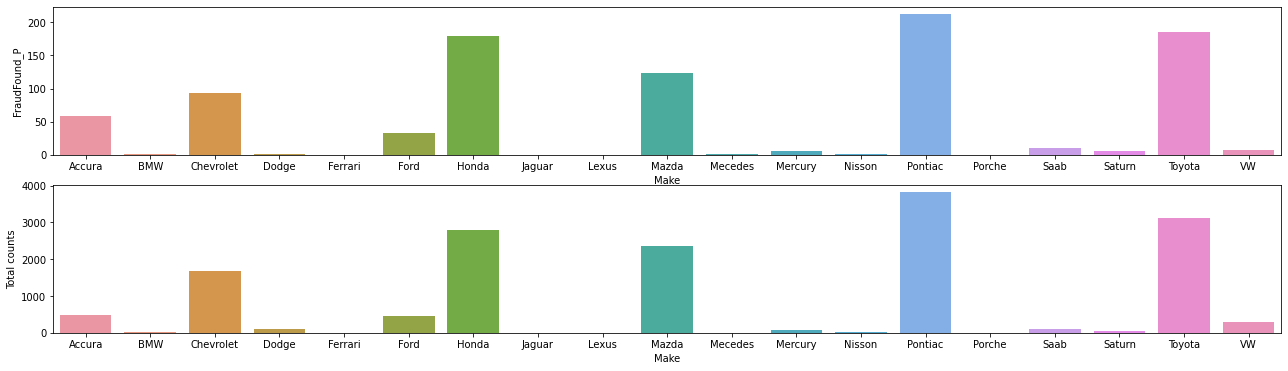

In [23]:
#plotting by FraudFound, looking to see if there are anything obvious that correlates to fraud
gpd_val1=df2.groupby('Make').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val2=df2.groupby('Make').agg('count').reset_index()

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(22, 6))
sns.barplot(x='Make', y='FraudFound_P', data = gpd_val1,ax=ax1)
sns.barplot(x='Make', y='FraudFound_P', data = gpd_val2,ax=ax2)

total_list = pd.concat([gpd_val1, gpd_val2['FraudFound_P'].rename('Total Accidents')],axis=1)
total_list['Percentage by Make']= round((total_list['FraudFound_P']/total_list['Total Accidents'])*100,3)
total_list['Percentage by Total'] = round((total_list['FraudFound_P']/sum(total_list['Total Accidents']))*100,3)

ax2.set(ylabel='Total counts')

data = [['Column total'],
        [sum(total_list['FraudFound_P'])], 
        [sum(total_list['Total Accidents'])], 
        [sum(total_list['Percentage by Make'])], 
        [sum(total_list['Percentage by Total'])]]

nr = pd.DataFrame(data)

nr1 = nr.transpose()
nr1.rename(columns={0:'Make',1:'FraudFound_P',2:'Total Accidents',3:'Percentage by Make',4:'Percentage by Total'}, inplace=True)
pd.concat([total_list,nr1],ignore_index=True)
                   
#print(tabulate(total_list, headers=total_list.columns))
                   
                   

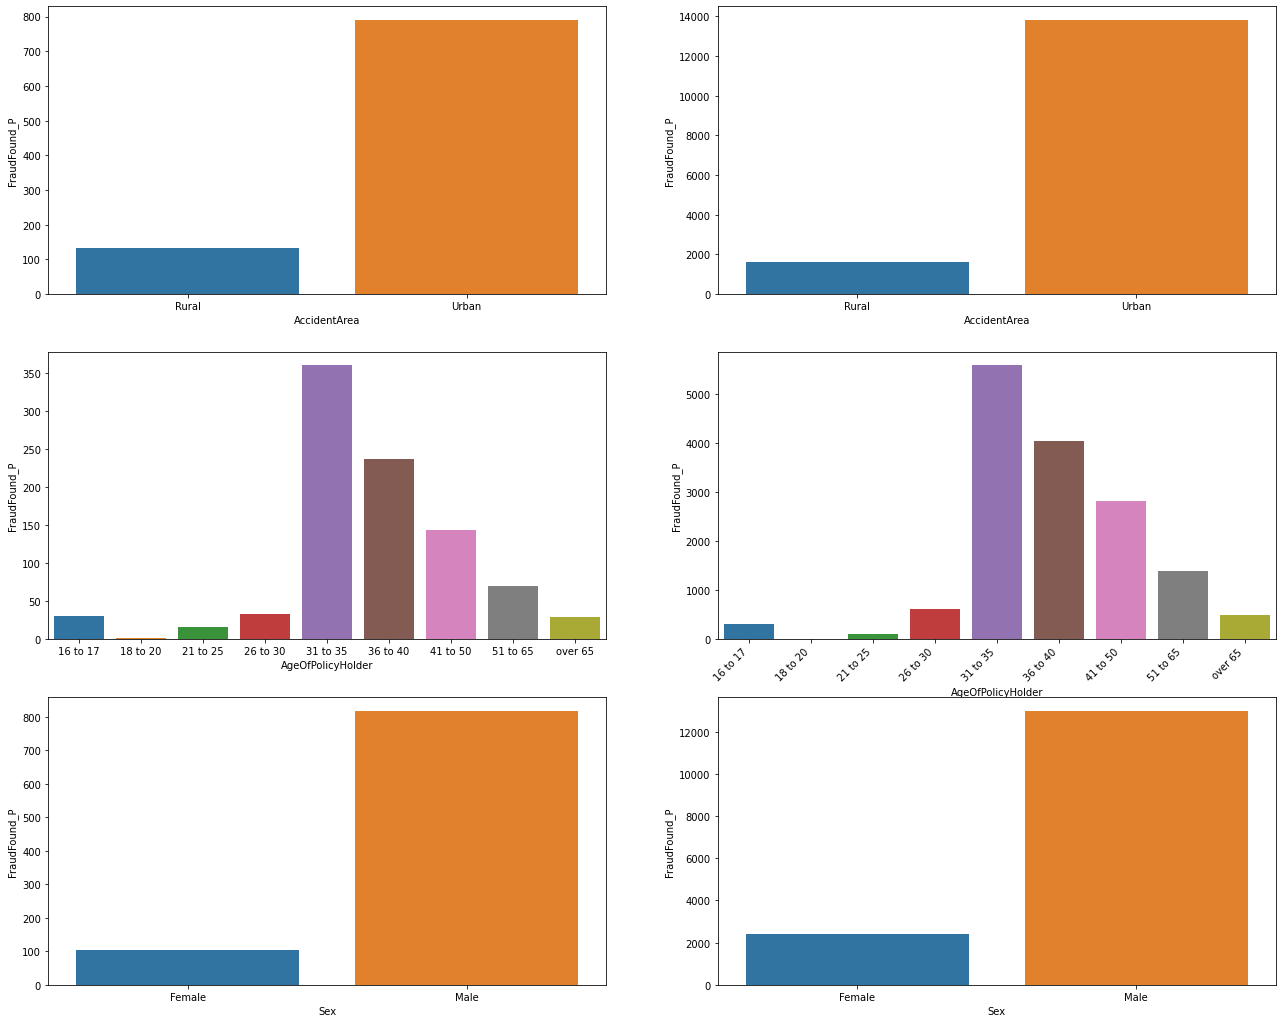

In [24]:
#AccidentArea, AgeOfPolicyHolder, Sex
gpd_val1=df2.groupby('AccidentArea').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val1_1=df2.groupby('AccidentArea').agg('count').reset_index()
gpd_val2=df2.groupby('AgeOfPolicyHolder').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val2_1=df2.groupby('AgeOfPolicyHolder').agg('count').reset_index()
gpd_val3=df2.groupby('Sex').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val3_1=df2.groupby('Sex').agg('count').reset_index()


fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(22, 18))
sns.barplot(x='AccidentArea', y='FraudFound_P', data = gpd_val1, ax=ax1)
sns.barplot(x='AccidentArea', y='FraudFound_P', data = gpd_val1_1, ax=ax2)

grph2 = sns.barplot(x='AgeOfPolicyHolder', y='FraudFound_P', data = gpd_val2, ax=ax3)
grph2 = sns.barplot(x='AgeOfPolicyHolder', y='FraudFound_P', data = gpd_val2_1, ax=ax4)

sns.barplot(x='Sex', y='FraudFound_P', data = gpd_val3, ax=ax5)
sns.barplot(x='Sex', y='FraudFound_P', data = gpd_val3_1, ax=ax6)


grph2.set_xticklabels(grph2.get_xticklabels(),
                    rotation=45,
                    horizontalalignment='right'
                    )
None

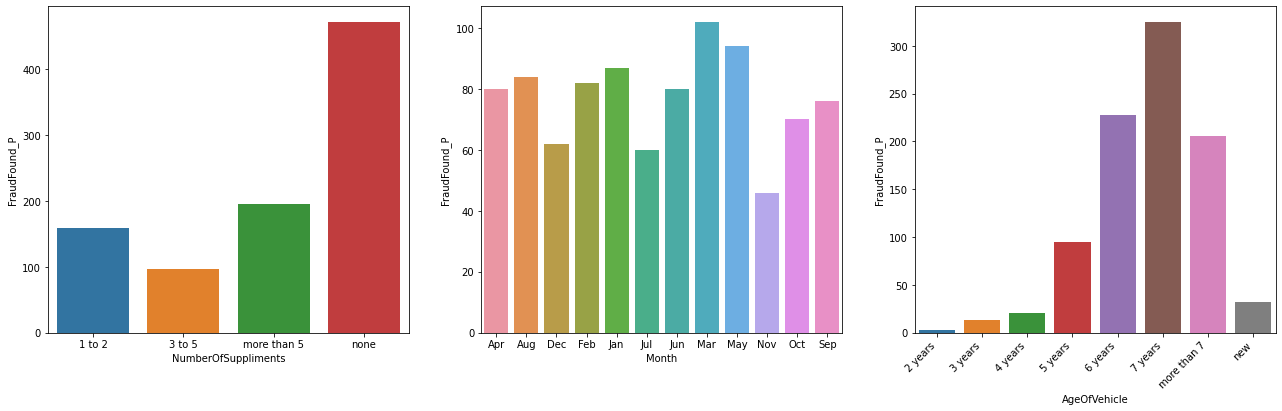

In [25]:
#NumberOfSuppliements, Month, AgeOfVehicle
gpd_val1=df2.groupby('NumberOfSuppliments').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val2=df2.groupby('Month').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val3=df2.groupby('AgeOfVehicle').agg({'FraudFound_P':'sum'}).reset_index()

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22, 6))
sns.barplot(x='NumberOfSuppliments', y='FraudFound_P', data = gpd_val1, ax=ax1)
sns.barplot(x='Month', y='FraudFound_P', data = gpd_val2, ax=ax2)
grph1 = sns.barplot(x='AgeOfVehicle', y='FraudFound_P', data = gpd_val3, ax=ax3)

grph1.set_xticklabels(grph1.get_xticklabels(),
                    rotation=45,
                    horizontalalignment='right'
                    )
None

923


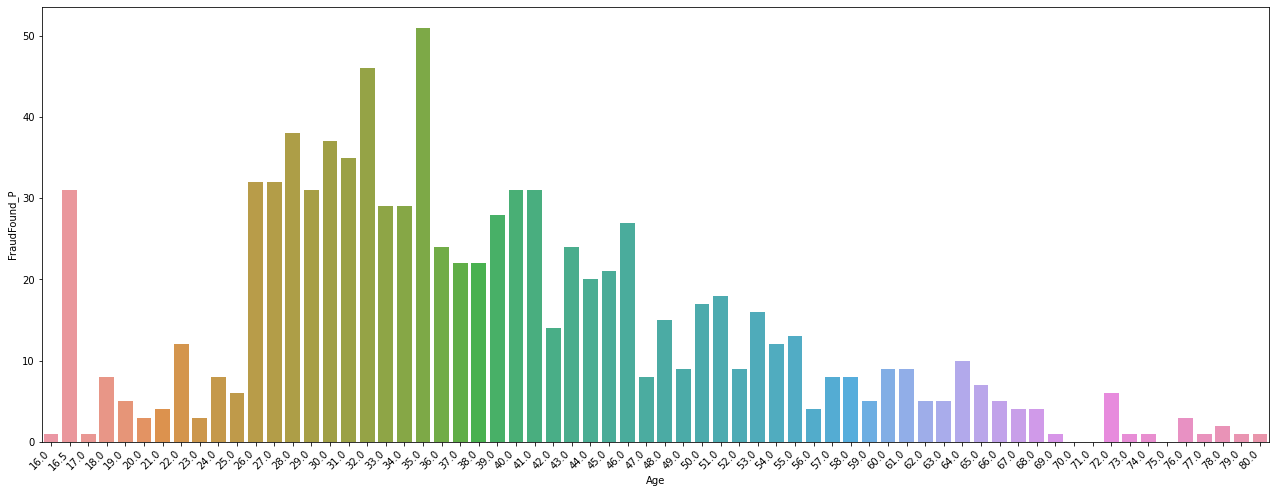

In [26]:
#plotting by FraudFound, looking to see if there are anything obvious that correlates to fraud
gpd_val1=df2.groupby('Age').agg({'FraudFound_P':'sum'}).reset_index()
print(gpd_val1['FraudFound_P'].sum())

fig, (ax1) = plt.subplots(1,1,figsize=(22, 8))
grph1=sns.barplot(x='Age', y='FraudFound_P', data = gpd_val1, ax=ax1)

grph1.set_xticklabels(grph1.get_xticklabels(),
                    rotation=45,
                    horizontalalignment='right'
                    )
None

<AxesSubplot:xlabel='Days_Policy_Accident', ylabel='FraudFound_P'>

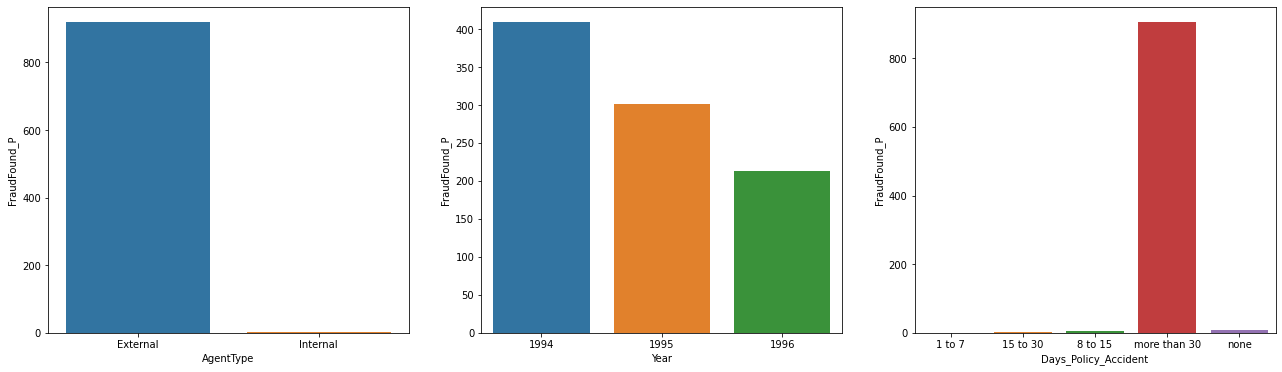

In [27]:
#AgentType, Year, Days_Policy_Accident
#plotting by FraudFound, looking to see if there are anything obvious that correlates to fraud
gpd_val1=df2.groupby('AgentType').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val2=df2.groupby('Year').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val3=df2.groupby('Days_Policy_Accident').agg({'FraudFound_P':'sum'}).reset_index()


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22, 6))
sns.barplot(x='AgentType', y='FraudFound_P', data = gpd_val1, ax=ax1)
sns.barplot(x='Year', y='FraudFound_P', data = gpd_val2, ax=ax2)
sns.barplot(x='Days_Policy_Accident', y='FraudFound_P', data = gpd_val3, ax=ax3)

<AxesSubplot:xlabel='DayOfWeek', ylabel='FraudFound_P'>

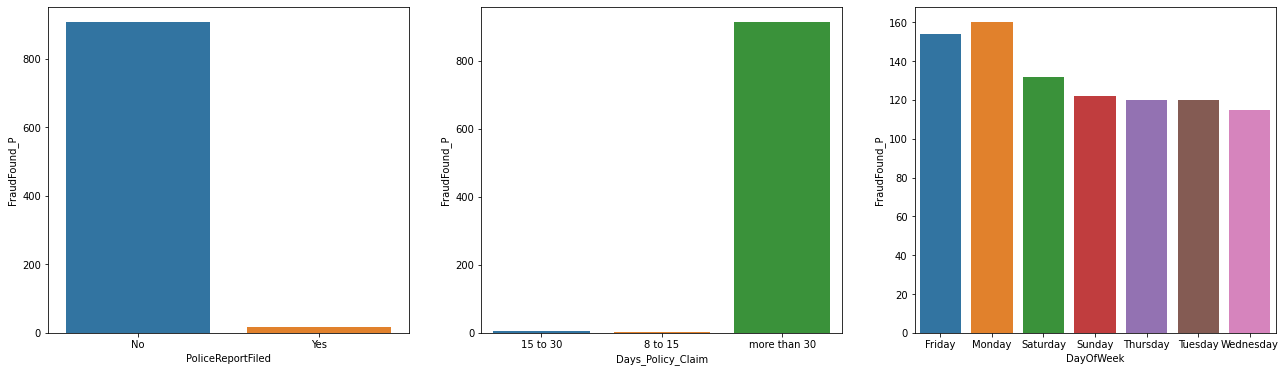

In [28]:
#PoliceReportFiled, Days_Policy_Claim, DayOfWeek
#plotting by FraudFound, looking to see if there are anything obvious that correlates to fraud
gpd_val1=df2.groupby('PoliceReportFiled').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val2=df2.groupby('Days_Policy_Claim').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val3=df2.groupby('DayOfWeek').agg({'FraudFound_P':'sum'}).reset_index()


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22, 6))
sns.barplot(x='PoliceReportFiled', y='FraudFound_P', data = gpd_val1, ax=ax1)
sns.barplot(x='Days_Policy_Claim', y='FraudFound_P', data = gpd_val2, ax=ax2)
sns.barplot(x='DayOfWeek', y='FraudFound_P', data = gpd_val3, ax=ax3)

<AxesSubplot:xlabel='DayOfWeekClaimed', ylabel='FraudFound_P'>

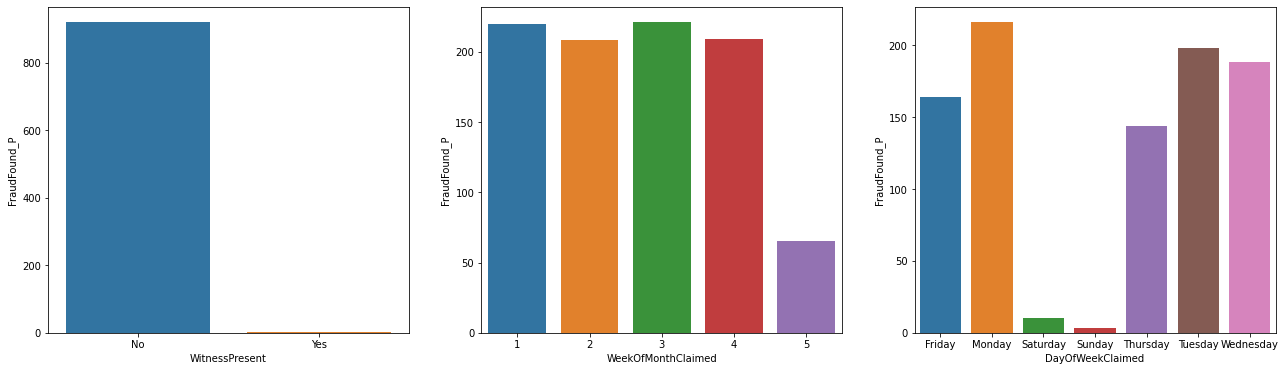

In [29]:
#WitnessPresent, WeekOfMonthClaimed, DayOfWeekClaimed
#plotting by FraudFound, looking to see if there are anything obvious that correlates to fraud
gpd_val1=df2.groupby('WitnessPresent').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val2=df2.groupby('WeekOfMonthClaimed').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val3=df2.groupby('DayOfWeekClaimed').agg({'FraudFound_P':'sum'}).reset_index()


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22, 6))
sns.barplot(x='WitnessPresent', y='FraudFound_P', data = gpd_val1, ax=ax1)
sns.barplot(x='WeekOfMonthClaimed', y='FraudFound_P', data = gpd_val2, ax=ax2)
sns.barplot(x='DayOfWeekClaimed', y='FraudFound_P', data = gpd_val3, ax=ax3)

<AxesSubplot:xlabel='NumberOfCars', ylabel='FraudFound_P'>

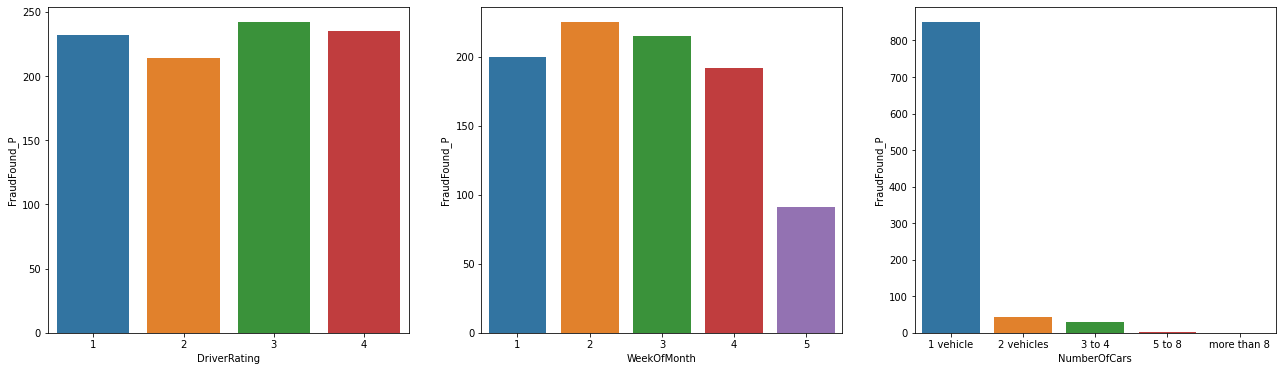

In [30]:
#DriverRating, WeekOfMonth, NumberOfCars
#plotting by FraudFound, looking to see if there are anything obvious that correlates to fraud
gpd_val1=df2.groupby('DriverRating').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val2=df2.groupby('WeekOfMonth').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val3=df2.groupby('NumberOfCars').agg({'FraudFound_P':'sum'}).reset_index()


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22, 6))
sns.barplot(x='DriverRating', y='FraudFound_P', data = gpd_val1, ax=ax1)
sns.barplot(x='WeekOfMonth', y='FraudFound_P', data = gpd_val2, ax=ax2)
sns.barplot(x='NumberOfCars', y='FraudFound_P', data = gpd_val3, ax=ax3)

<AxesSubplot:xlabel='RepNumber', ylabel='FraudFound_P'>

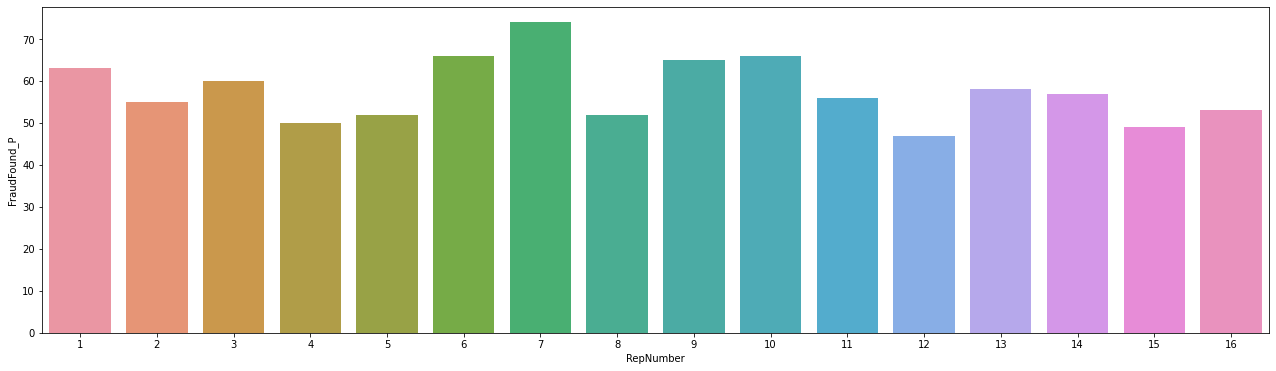

In [31]:
#plotting by FraudFound, looking to see if there are anything obvious that correlates to fraud
gpd_val2=df2.groupby('RepNumber').agg({'FraudFound_P':'sum'}).reset_index()
gpd_valt2=df2.groupby('RepNumber').agg({'FraudFound_P':'sum'}).reset_index()

fig, (ax2) = plt.subplots(1,1,figsize=(22, 6))
sns.barplot(x='RepNumber', y='FraudFound_P', data = gpd_val2, ax=ax2)

<AxesSubplot:xlabel='MaritalStatus', ylabel='FraudFound_P'>

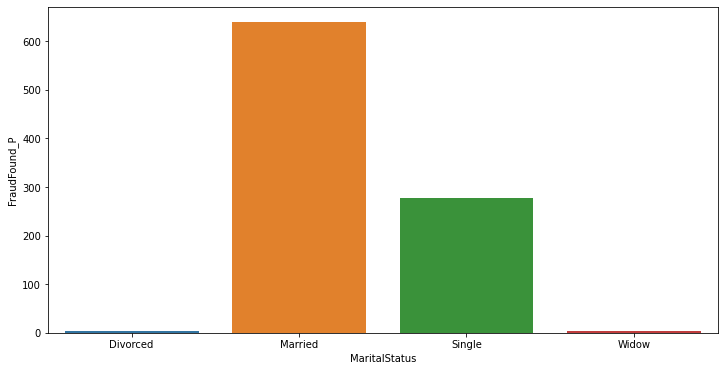

In [32]:
#plotting by FraudFound, looking to see if there are anything obvious that correlates to fraud
gpd_val1=df2.groupby('MaritalStatus').agg({'FraudFound_P':'sum'}).reset_index()
#gpd_val2=df2.groupby('MaritalStatus').agg('count').reset_index()

fig, (ax1) = plt.subplots(1,1,figsize=(12, 6))
sns.barplot(x='MaritalStatus', y='FraudFound_P', data = gpd_val1, ax=ax1)
#sns.barplot(x='MaritalStatus', y='FraudFound_P', data = gpd_val2, ax=ax2)


In [33]:
# Save to intermediate data
df2.to_csv('../data/02_intermediate/fraud_clean.csv')
df2.to_csv('../data/03_primary/fraud_clean.csv')

# **PART 6:** Splitting data into dependent and independent variables.

We split the data into the dependent feature ('FraudFound_P') and the independent features (everything else).

In [34]:
X=df2.drop('FraudFound_P',axis=1).copy()
y=df2['FraudFound_P'].copy()

# **PART 7:** Encoding the data.   
       

We have taken care of missing values in Age, DayOfWeekClaimed, and MonthClaimed.
Next, we will convert the following features to 1's and 0's.
* AccidentArea:        
    * 1=Urban,         0=Rural
* Sex:
    * 1=Female,        0=Male
* Fault: 
    * 1=Policy Holder, 0=Third Party
* PoliceReportFiled: 
    * 1=Yes,           0=No
* WitnessPresent: 
    * 1=Yes,           0=No
* AgentType:   
    * 1=External       0=Internal

In [51]:
cols = ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']
y_val = ['Urban','Female','Policy Holder', 'Yes', 'Yes','External']
x_val = ['Rural', 'Male', 'Third Party', 'No', 'No', 'Internal']

for i in range(len(cols)):
    X_idx1 = X[cols[i]]==y_val[i]
    X_idx2 = X[cols[i]]==x_val[i]

    X.loc[list(X_idx1),cols[i]]=1
    X.loc[list(X_idx2),cols[i]]=0

In [52]:
for i in range(len(cols)):
    X[cols[i]] = X[cols[i]].astype('int')

In [53]:
X.dtypes

Month                    object
WeekOfMonth               int64
DayOfWeek                object
Make                     object
AccidentArea              int64
DayOfWeekClaimed         object
MonthClaimed             object
WeekOfMonthClaimed        int64
Sex                       int64
MaritalStatus            object
Age                     float64
Fault                     int64
PolicyType               object
VehicleCategory          object
VehiclePrice             object
PolicyNumber              int64
RepNumber                 int64
Deductible                int64
DriverRating              int64
Days_Policy_Accident     object
Days_Policy_Claim        object
PastNumberOfClaims       object
AgeOfVehicle             object
AgeOfPolicyHolder        object
PoliceReportFiled         int64
WitnessPresent            int64
AgentType                 int64
NumberOfSuppliments      object
AddressChange_Claim      object
NumberOfCars             object
Year                      int64
BasePoli

Next we convert the following features to be numeric, we will use ordinal encoder from catergory_encoders.ordinal (I discovered that this produces an intger encoding even if I specified a float with an explicit mapping. To get around this I used the replace() method to encode the features I needed as floats).
* Month
* DayOfWeek
* DayOfWeekClaimed
* MonthClaimed
* PastNumberOfClaims
* NumberOfSuppliments
* VehiclePrice
* Day_Policy_Accident
* Days_Policy_Claim
* AgeOfVehicle
* AgeOfPolicyHolder
* AddressChange_Claim
* NumberOfCars


In [54]:
col_ordering = [{'col':'Month','mapping':{'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}},
    {'col':'DayOfWeek','mapping':{'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}},
    {'col':'DayOfWeekClaimed','mapping':{'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}},
    {'col':'MonthClaimed','mapping':{'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}},
    {'col':'PastNumberOfClaims','mapping':{'none':0 ,'1':1,'2 to 4':2,'more than 4':5 }},
    {'col':'NumberOfSuppliments','mapping':{'none':0,'1 to 2':1,'3 to 5':3,'more than 5':6}}, 
    {'col':'VehiclePrice','mapping':{'more than 69000':69001,'20000 to 29000':24500,'30000 to 39000':34500,'less than 20000':19999,
                                     '40000 to 59000':49500,'60000 to 69000':64500}},
    {'col':'AgeOfVehicle','mapping':{'3 years':3,'6 years':6,'7 years':7,'more than 7':8,'5 years':5,'new':0,'4 years':4,'2 years':2}},
]
ord_encoder = OrdinalEncoder(mapping = col_ordering, return_df=True)

In [55]:
X2 = ord_encoder.fit_transform(X)

In [56]:
col_map = [{'Days_Policy_Accident':{'more than 30':31,'15 to 30':22.5,'none':0,'1 to 7':4,'8 to 15':11.5}},
    {'Days_Policy_Claim':{'more than 30':31,'15 to 30':22.5,'8 to 15':11.5,'none':0}},
    {'AgeOfPolicyHolder':{'26 to 30':28,'31 to 35':33,'41 to 50':45.5,'51 to 65':58,'21 to 25':23,'36 to 40':38,'16 to 17':16.5,
                                          'over 65':66,'18 to 20':19}},
    {'AddressChange_Claim':{'1 year':1,'no change':0,'4 to 8 years':6,'2 to 3 years':2.5,'under 6 months':0.5}},
    {'NumberOfCars':{'3 to 4':3.5,'1 vehicle':1,'2 vehicles':2,'5 to 8':6.5,'more than 8':9}},
]

X3 = X2.copy()
for i in range(len(col_map)):
    X3.replace(col_map[i], inplace=True)

In [39]:
X3.dtypes

Month                     int64
WeekOfMonth               int64
DayOfWeek                 int64
Make                     object
AccidentArea              int64
DayOfWeekClaimed          int64
MonthClaimed              int64
WeekOfMonthClaimed        int64
Sex                       int64
MaritalStatus            object
Age                     float64
Fault                     int64
PolicyType               object
VehicleCategory          object
VehiclePrice              int64
PolicyNumber              int64
RepNumber                 int64
Deductible                int64
DriverRating              int64
Days_Policy_Accident    float64
Days_Policy_Claim       float64
PastNumberOfClaims        int64
AgeOfVehicle              int64
AgeOfPolicyHolder       float64
PoliceReportFiled         int64
WitnessPresent            int64
AgentType                 int64
NumberOfSuppliments       int64
AddressChange_Claim     float64
NumberOfCars            float64
Year                      int64
BasePoli

Need to convert the following features to a numeric.
* Make
* MaritalStatus
* PolicyType

I am currently looking into the best way to encode this features. For the time being I am simply using One-hot encoding.


In [57]:
#implementing one-hot encoding
one_hot_encoder = OneHotEncoder(cols = ['Make','MaritalStatus','PolicyType','VehicleCategory','BasePolicy'],use_cat_names=True, return_df=True) 

#implementing label encoding, with random assignment of integers to each label
# assumes no natrual underlying order to the feature labels
ord_encoder1 = OrdinalEncoder(cols = ['Make','MaritalStatus','PolicyType','VehicleCategory','BasePolicy'],return_df=True)

#implementing binary encoding
#represents the data 
bi_encoder = BinaryEncoder(cols = ['Make','MaritalStatus','PolicyType','VehicleCategory','BasePolicy'], return_df=True)


In [58]:
#implimented a simple switch to change how I wanted to encode the variables
#Allowed for a updating the independet variables quickly and not missing a code box

switch_val = 0
if switch_val ==0:
    X4 = one_hot_encoder.fit_transform(X3)
elif switch_val==1:
    X4 = ord_encoder1.fit_transform(X3)
else:
    X4 = bi_encoder.fit_transform(X3)


In [59]:
X4.dtypes


Month                      int64
WeekOfMonth                int64
DayOfWeek                  int64
Make_Honda                 int64
Make_Toyota                int64
                          ...   
NumberOfCars             float64
Year                       int64
BasePolicy_Liability       int64
BasePolicy_Collision       int64
BasePolicy_All Perils      int64
Length: 65, dtype: object

In [43]:
chi_result=[]
for feat in X4.columns:
    chi2, p, dof, ex = stats.chi2_contingency(pd.crosstab(X4[feat], y))
    chi_result.append([feat,chi2,p])

ch_df = pd.DataFrame(chi_result, columns=['Feature', 'Chi2 val', 'p-val'])
ch_df.sort_values(by=['p-val'], inplace=True)

print(tabulate(ch_df, headers=['Feature', 'Chi2 val', 'p-val']))

    Feature                                 Chi2 val        p-val
--  -------------------------------  ---------------  -----------
62  BasePolicy_Liability               364.39         3.11662e-81
35  PolicyType_Sedan - Liability       361.582        1.27387e-80
42  VehicleCategory_Sport              283.641        1.20855e-63
32  Fault                              264.985        1.40618e-59
44  VehicleCategory_Sedan              229.175        9.02161e-52
64  BasePolicy_All Perils              192.648        8.40081e-44
37  PolicyType_Sedan - All Perils      162.857        2.68872e-37
59  AddressChange_Claim                104.723        9.70472e-22
48  Deductible                          72.4063       1.30283e-15
45  VehiclePrice                        67.8361       2.88832e-13
52  PastNumberOfClaims                  53.5418       1.4052e-11
34  PolicyType_Sport - Collision        37.1525       1.09243e-09
 9  Make_Accura                         35.5259       2.51688e-09
63  BasePol

In [44]:
tempy_x4 = pd.DataFrame(X4.corrwith(y,axis=0 ).sort_values(ascending=False))
print(tabulate(tempy_x4, headers=['Feature', 'Pearson Correlation']))


Feature                            Pearson Correlation
-------------------------------  ---------------------
Fault                                      0.131401
VehicleCategory_Sedan                      0.122197
BasePolicy_All Perils                      0.112079
PolicyType_Sedan - All Perils              0.103082
PolicyType_Sport - Collision               0.0500073
Make_Accura                                0.0487938
BasePolicy_Collision                       0.0438481
PolicyType_Utility - All Perils            0.0384385
VehiclePrice                               0.037556
VehicleCategory_Utility                    0.0358128
PolicyType_Sedan - Collision               0.02829
AgentType                                  0.0229803
DayOfWeek                                  0.0174298
Deductible                                 0.0173451
Make_Saab                                  0.014866
Make_Mecedes                               0.012911
AddressChange_Claim                        0.012797

In [45]:
#X5 = X4.drop(columns=['VehicleCategory','BasePolicy'])
#X5.dtypes

# **PART 8:** Build preliminary classification tree


To get a feel for the challenge we face and how the dataset behaves, I decided to implement a basic Decision Tree.

In [46]:
#this code takes our data after cleaning and splits it into the testing set and training set

X_train, X_test, y_train, y_test = train_test_split(X4, y,stratify=y, random_state=42)
clf_dt_m1 = DecisionTreeClassifier(random_state=42)
clf_dt1 = clf_dt_m1.fit(X_train, y_train)


In [47]:
y_pred_gini = clf_dt1.predict(X_test)

print('Gini stats')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_gini))
print("balanced_accuracy:",metrics.balanced_accuracy_score(y_test, y_pred_gini))
print("brier_score_loss:",metrics.brier_score_loss(y_test, y_pred_gini))
print("f1_score:",metrics.f1_score(y_test,y_pred_gini))
print("recall_score:",metrics.recall_score(y_test, y_pred_gini))
print("precision_score:",metrics.precision_score(y_test, y_pred_gini))
print("roc_auc_score:",metrics.roc_auc_score(y_test, y_pred_gini))


Gini stats
Accuracy: 0.9151750972762646
balanced_accuracy: 0.661036810871248
brier_score_loss: 0.08482490272373541
f1_score: 0.34468937875751504
recall_score: 0.3722943722943723
precision_score: 0.3208955223880597
roc_auc_score: 0.6610368108712481


Looking at the above metrics, it is clear that our tree is having trouble identifying the true positves (recall score of .372). This led me to the decision try applying some ensemble and boosting methods to get better results.

True Negatives: 3442
False Postives: 182
False Negatives: 145
True Positive: 86
Recall: 0.3722943722943723
Precision: 0.3208955223880597
Prevalence: 0.05992217898832685


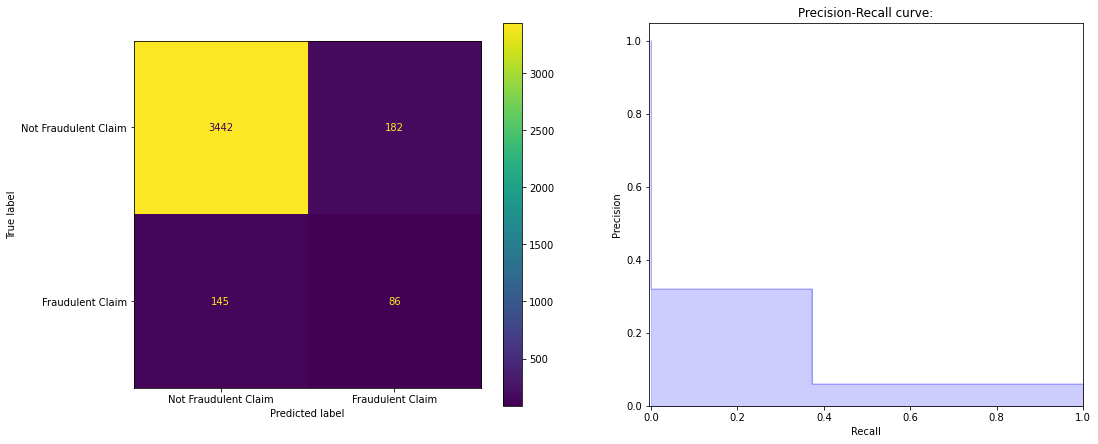

In [48]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_gini)

#this code plots the confusion matrix of our niave implementation of a decision tree
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.tight_layout(pad=5.0)
metrics.plot_confusion_matrix(clf_dt1, X_test, y_test, display_labels=["Not Fraudulent Claim", "Fraudulent Claim"], ax=ax1)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_gini).ravel()

ax2.step(recall, precision, color='b', alpha=0.2, where='post')
ax2.fill_between(recall, precision, step='post', alpha=0.2, color='b')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_ylim([0.0, 1.05])
ax2.set_xlim([-0.005, 1.0])
ax2.set_title('Precision-Recall curve:')


print('True Negatives:', tn)
print('False Postives:', fp)
print('False Negatives:', fn)
print('True Positive:', tp)
print('Recall:', tp/(fn+tp))
print('Precision:', tp/(fp+tp))
print('Prevalence:', (fn+tp)/(tn+fp+fn+tp))

The results of our nieve implementation of a Decision tree has return underwhelming results in terms of identifying fraud cases. 

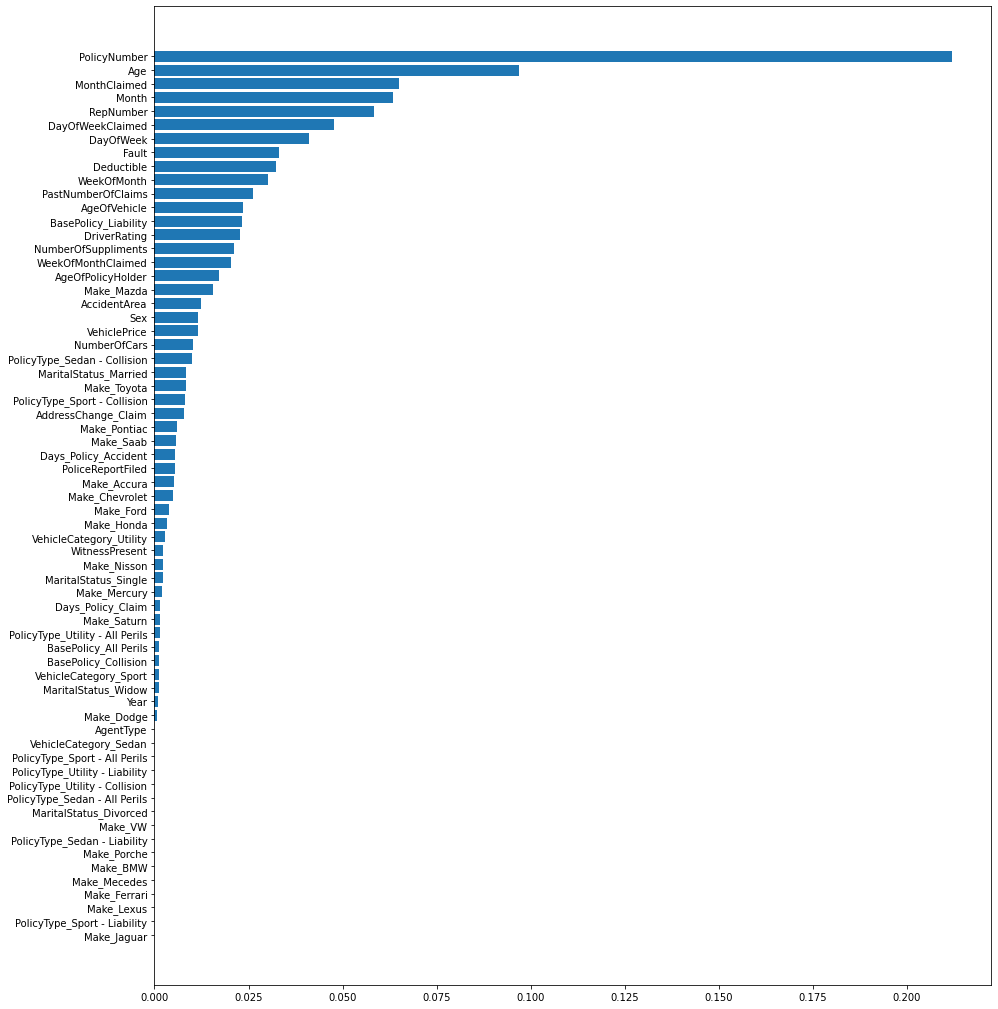

In [49]:
important_tree_features = clf_dt1.feature_importances_

indices = np.argsort(important_tree_features)

fig, ax = plt.subplots(figsize=(15, 18))
ax.barh(range(len(important_tree_features)), important_tree_features[indices])
ax.set_yticks(range(len(important_tree_features)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

# **PART 9:** Comparing Decision Trees, Random Forest, AdaBoost, and XGBoost

In [50]:
classifiers = {
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, objective= 'binary:logistic',eval_metric='aucpr'),
}

In [51]:
df_models = pd.DataFrame(columns = ['model', 
                                    'run_time', 
                                    'avg_accy',
                                    'avg_accy_std',  
                                    'avg_recall',
                                    'avg_recall_std',
                                    'avg_precision',
                                    'avg_precision_std',
                                    'avg_f1',
                                    'avg_f1_std',
                                    'avg_matthew_corcoef',
                                    'avg_matthew_corcoef_std',
                                    'avg_roc_auc',
                                    'avg_roc_auc_std', 
                                     ])


scorer = {'accuracy_score':metrics.make_scorer(metrics.accuracy_score),
          'f1_score':metrics.make_scorer(metrics.f1_score),
          'recall_score':metrics.make_scorer(metrics.recall_score),
          'precision_score':metrics.make_scorer(metrics.average_precision_score),
          'matthew_corrcoef':metrics.make_scorer(metrics.matthews_corrcoef),
          'roc_auc_score':metrics.make_scorer(metrics.roc_auc_score) 
         }

for key in classifiers:
    print('*', key)
    start_time = time.time()
    classifier = classifiers[key]
    model = classifier.fit(X_train,y_train)
    cvs = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    cv_scores = cross_validate(model, X_test, y_test, cv=cvs, scoring = scorer)
    y_pred = model.predict(X_test)
    
    row = {
        'model': key,
        'run_time': format(round((time.time() - start_time)/60,2)),
        'avg_accy': cv_scores['test_accuracy_score'].mean(),
        'avg_accy_std': cv_scores['test_accuracy_score'].std(),
        'avg_recall': cv_scores['test_recall_score'].mean(),
        'avg_recall_std': cv_scores['test_recall_score'].std(),
        'avg_precision': cv_scores['test_precision_score'].mean(),
        'avg_precision_std': cv_scores['test_precision_score'].std(),
        'avg_f1': cv_scores['test_f1_score'].mean(),
        'avg_f1_std': cv_scores['test_f1_score'].std(),
        'avg_matthew_corcoef': cv_scores['test_matthew_corrcoef'].mean(),
        'avg_matthew_corcoef_std': cv_scores['test_matthew_corrcoef'].std(),
        'avg_roc_auc': cv_scores['test_roc_auc_score'].mean(),
        'avg_roc_auc_std': cv_scores['test_roc_auc_score'].std(),
    }
    
    df_models = df_models.append(row, ignore_index=True)
    

* DecisionTreeClassifier
* RandomForestClassifier


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classific

* AdaBoostClassifier


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


* XGBClassifier


In [52]:
df_models.head()

,model,run_time,avg_accy,avg_accy_std,avg_recall,avg_recall_std,avg_precision,avg_precision_std,avg_f1,avg_f1_std,avg_matthew_corcoef,avg_matthew_corcoef_std,avg_roc_auc,avg_roc_auc_std
0,DecisionTreeClassifier,0.02,0.893557,0.011889,0.216184,0.097994,0.092206,0.027460,0.194163,0.082508,0.139234,0.088457,0.576450,0.049921
1,RandomForestClassifier,0.27,0.940078,0.000755,0.000000,0.000000,0.059922,0.000755,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000
2,AdaBoostClassifier,0.17,0.937225,0.003497,0.011594,0.022264,0.066355,0.016455,0.021042,0.040572,0.024889,0.076083,0.503911,0.011418
3,XGBClassifier,0.42,0.942843,0.006800,0.149940,0.076236,0.151013,0.064634,0.234856,0.106642,0.274324,0.120731,0.571658,0.038723


Comparing the different methods and metrics we see that the Decision Tree Classifier and XGBClassifier were the most successful, judged by the average F1 score and Matthew Correlation Coefficient from the 10-fold cross-validation. Of the four methods tested the DecisionTreeClassifier and XGBClassifier are the top candidates for our model.

A common recommendation online for improving performance is to over-sample the minorty class or under-sample the majority class or both. In the next experiment I retest the four methods with a training set on which I applied the SMOTE algorithm. Perhaps this would change the results and we would see a clear winner from one of the methods.

# **PART 10:** Comparing DT, RF, Ada, XGB with SMOTE

In [53]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(y_train.value_counts())
print(y_train_res.value_counts())

0    10872
1      692
Name: FraudFound_P, dtype: int64
0    10872
1    10872
Name: FraudFound_P, dtype: int64


Applied SMOTE to the training data and confirmed the new train set has an equal distribution of target feature.

In [54]:
df_models_smote = pd.DataFrame(columns = ['model', 
                                    'run_time', 
                                    'avg_accy',
                                    'avg_accy_std',  
                                    'avg_recall',
                                    'avg_recall_std',
                                    'avg_precision',
                                    'avg_precision_std',
                                    'avg_f1',
                                    'avg_f1_std',
                                    'avg_matthew_corcoef',
                                    'avg_matthew_corcoef_std',
                                    'avg_roc_auc',
                                    'avg_roc_auc_std', 
                                     ])


scorer = {'accuracy_score':metrics.make_scorer(metrics.accuracy_score),
          'f1_score':metrics.make_scorer(metrics.f1_score),
          'recall_score':metrics.make_scorer(metrics.recall_score),
          'precision_score':metrics.make_scorer(metrics.precision_score),
          'matthew_corrcoef':metrics.make_scorer(metrics.matthews_corrcoef),
          'roc_auc_score':metrics.make_scorer(metrics.roc_auc_score) 
         }

for key in classifiers:
    print('*', key)
    start_time = time.time()
    classifier = classifiers[key]
    model = classifier.fit(X_train_res,y_train_res)     #<--- pass the SMOTE generate training data set
    #scorer = metrics.make_scorer(metrics.recall_score)
    #cv_scores = cross_val_score(model, X_test, y_test, cv=5, scoring=scorer)
    cvs = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    cv_scores = cross_validate(model, X_test, y_test, cv=cvs, scoring = scorer)   #<--- tested the SMOTE trained model on original testing data
    y_pred = model.predict(X_test)
    
    #print(model.get_params())
    
    row = {
        'model': key,
        'run_time': format(round((time.time() - start_time)/60,2)),
        'avg_accy': cv_scores['test_accuracy_score'].mean(),
        'avg_accy_std': cv_scores['test_accuracy_score'].std(),
        'avg_recall': cv_scores['test_recall_score'].mean(),
        'avg_recall_std': cv_scores['test_recall_score'].std(),
        'avg_precision': cv_scores['test_precision_score'].mean(),
        'avg_precision_std': cv_scores['test_precision_score'].std(),
        'avg_f1': cv_scores['test_f1_score'].mean(),
        'avg_f1_std': cv_scores['test_f1_score'].std(),
        'avg_matthew_corcoef': cv_scores['test_matthew_corrcoef'].mean(),
        'avg_matthew_corcoef_std': cv_scores['test_matthew_corrcoef'].std(),
        'avg_roc_auc': cv_scores['test_roc_auc_score'].mean(),
        'avg_roc_auc_std': cv_scores['test_roc_auc_score'].std(),
    }
    
    df_models_smote = df_models_smote.append(row, ignore_index=True)

* DecisionTreeClassifier
* RandomForestClassifier


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn

* AdaBoostClassifier


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn

* XGBClassifier


In [55]:
df_models.head()


,model,run_time,avg_accy,avg_accy_std,avg_recall,avg_recall_std,avg_precision,avg_precision_std,avg_f1,avg_f1_std,avg_matthew_corcoef,avg_matthew_corcoef_std,avg_roc_auc,avg_roc_auc_std
0,DecisionTreeClassifier,0.02,0.893557,0.011889,0.216184,0.097994,0.092206,0.027460,0.194163,0.082508,0.139234,0.088457,0.576450,0.049921
1,RandomForestClassifier,0.27,0.940078,0.000755,0.000000,0.000000,0.059922,0.000755,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000
2,AdaBoostClassifier,0.17,0.937225,0.003497,0.011594,0.022264,0.066355,0.016455,0.021042,0.040572,0.024889,0.076083,0.503911,0.011418
3,XGBClassifier,0.42,0.942843,0.006800,0.149940,0.076236,0.151013,0.064634,0.234856,0.106642,0.274324,0.120731,0.571658,0.038723


In [56]:
df_models_smote.head()

,model,run_time,avg_accy,avg_accy_std,avg_recall,avg_recall_std,avg_precision,avg_precision_std,avg_f1,avg_f1_std,avg_matthew_corcoef,avg_matthew_corcoef_std,avg_roc_auc,avg_roc_auc_std
0,DecisionTreeClassifier,0.02,0.893814,0.014769,0.198792,0.103173,0.170826,0.088191,0.182240,0.092894,0.127302,0.099135,0.568445,0.053253
1,RandomForestClassifier,0.29,0.940078,0.000755,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000
2,AdaBoostClassifier,0.18,0.937225,0.003497,0.011594,0.022264,0.130556,0.275280,0.021042,0.040572,0.024889,0.076083,0.503911,0.011418
3,XGBClassifier,0.46,0.942843,0.006800,0.149940,0.076236,0.591532,0.216708,0.234856,0.106642,0.274324,0.120731,0.571658,0.038723


Looking over the two results, we can see that using SMOTE with the DecisionTreeClassifier resulted in a similar F1 score as to the non-SMOTE model (during testing I have seen both a slight increase and decrease in performance, which is expected since we randomly selecting the dataset during the cross-validation process). The ensemble methods showed no change in the F1 score or Matthew Correlation Coefficient. This is where I decided to continue bulding a model using the XGBClassifier because of the consistency of the F1 score and Matthew Correlation Coefficient.

# **PART 11:** Tuning the hyperparameters of XGBoost

The process of getting the hyperparameters tuned was a long fight for me. I found lots of blog posts and code that 'demonstrated' how to do it, but either part of the code or all of the code didn't work or made no sense. I am firm believer that there are no magic bullets, so if I find code that 'works' but makes no sense in how it generates the results I assume it is useless. 

My first attempt I used GridSearchCV to work the parameter space but took a god-awful amount of time (based on https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/). I very quickly abandonded that idea and went search for a better/faster method. I came across the following article, (https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f), and the method actually work very fast, but I didn't understand why/how it worked and when I went to compare the results to the previous methods I had difficulty extracting the optimal parameters for a separate verification using XGBClassifier (as opposed to using dmatrix and xgb). 

After further searching and reading I came across two articles which lead me to Hyperopt and is what the following code is based on. The first being the most helpful, strongly recommend anyone interested to read through it.
* https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning 
* https://machinelearningmastery.com/hyperopt-for-automated-machine-learning-with-scikit-learn/

Below I created the parameter space for my XGBClassifier. There were inconsistencies in results so I opted to explicitly define all the parameters that XGBClassifier takes.


In [57]:
space={
    'objective': 'binary:logistic',
    #objective= 'binary:logistic', 
    'use_label_encoder': False,
    #use_label_encoder= False, 
    'base_score': 0.5,
    #base_score= 0.5, 
    'booster': 'gbtree',
    #booster= 'gbtree', 
    'colsample_bylevel' : 1,
    #colsample_bylevel= 1, 
    'colsample_bynode' : 1,
    #colsample_bynode= 1, 
    'colsample_bytree' : 1,
    #colsample_bytree= 1, 
    'enable_categorical': False,
    #enable_categorical= False, 
    'gamma': hp.uniform('gamma', 0,10),
    #gamma= 0, 
    'gpu_id': -1,
    #gpu_id= -1,
    'importance_type': None,
    #importance_type= None, 
    'interaction_constraints': '',
    #interaction_constraints= '', 
    'learning_rate': 0.300000012,
    #learning_rate= 0.300000012, 
    'max_delta_step': 0,
    #max_delta_step= 0, 
    'max_depth': hp.randint("max_depth", 10)+3,
    #max_depth= 6, 
    'min_child_weight' : hp.randint('min_child_weight', 4)+1,
    #min_child_weight= 1, 
    #missing= 'nan', 
    'monotone_constraints': '()',
    #monotone_constraints= '()',
    'n_estimators': hp.randint('n_estimators', 150)+50,
    #n_estimators= 100, 
    'n_jobs': 4,
    #n_jobs= 4, 
    'num_parallel_tree':1,
    #num_parallel_tree= 1, 
    'predictor':'auto',
    #predictor= 'auto', 
    'random_state': 0,
    #random_state= 0, 
    'reg_alpha' : hp.randint('reg_alpha', 10),
    #reg_alpha= 0, 
    'reg_lambda' : hp.randint('reg_lambda', 10),
    #reg_lambda= 1, 
    'scale_pos_weight': 1,
    #scale_pos_weight= 1, 
    'subsample': 1,
    #subsample= 1, 
    'tree_method': 'exact',
    #tree_method= 'exact', 
    'validate_parameters':1,
    #validate_parameters= 1, 
    'verbosity': None,
    #verbosity= None, 
    'eval_metric': 'aucpr'
    #eval_metric= 'aucpr'
    }


In [58]:
high_roc_scores = {}
#model_num = 0

def objective(space):
    #model_num +=1
    clf_model=XGBClassifier(**space)
    fitted_model=clf_model.fit(X_train, y_train)
    pred = fitted_model.predict(X_test)
    
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred).ravel()
    accuracy = metrics.accuracy_score(y_test, pred)
    precision = metrics.precision_score(y_test, pred)
    recall = metrics.recall_score(y_test, pred)
    f1 = metrics.f1_score(y_test,pred)
    matthew_corrcoef = metrics.matthews_corrcoef(y_test,pred),
    roc_auc = metrics.roc_auc_score(y_test,pred)
    avg_precision = metrics.average_precision_score(y_test, pred)
    
    rows = {'model': ' XGBClassifier',
        'tp': [tp],
        'tn': [tn],
        'fp': [fp],
        'fn': [fn],
        'accuracy': [round(accuracy,3)],
        'precision': [round(precision,3)],
        'recall':[ round(recall,3)],
        'f1': [round(f1,3)],
        'matthews_coef': [round(matthew_corrcoef[0],3)],
        'roc_auc': [round(roc_auc,3)],
        'avg_pre': [round(avg_precision,3)],
    }
     
    score_vals = pd.DataFrame(rows)
    print(tabulate(score_vals, headers=score_vals.columns))
    print(' ')
    if round(roc_auc,3)>0.7:
        high_roc_scores['Trial_model_{}'.format(time.time())]= [fitted_model.get_params(), score_vals]
        print(' ')
        print(fitted_model.get_params())
        print(' ')
        print(' ')
        print(' ')
    
    return {'loss': -roc_auc, 'status': STATUS_OK }

In [59]:
trials=Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                       trials=trials)

    model            tp    tn    fp    fn    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  XGBClassifier     6  3624     0   225       0.942            1     0.026  0.051            0.156      0.513      0.084
    model            tp    tn    fp    fn    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  XGBClassifier    25  3615     9   206       0.944        0.735     0.108  0.189            0.268      0.553      0.133
    model            tp    tn    fp    fn    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  XGBClassifie

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



    model            tp    tn    fp    fn    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  XGBClassifier    62  3610    14   169       0.953        0.816     0.268  0.404            0.452      0.632      0.263
    model            tp    tn    fp    fn    accuracy    precision    recall    f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  ----  ---------------  ---------  ---------
 0  XGBClassifier     0  3624     0   231        0.94            0         0     0                0        0.5       0.06
 15%|█▌        | 15/100 [00:43<03:48,  2.68s/trial, best loss: -0.6906661219575126]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



    model            tp    tn    fp    fn    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  XGBClassifier     6  3624     0   225       0.942            1     0.026  0.051            0.156      0.513      0.084
    model            tp    tn    fp    fn    accuracy    precision    recall    f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  ----  ---------------  ---------  ---------
 0  XGBClassifier     0  3624     0   231        0.94            0         0     0                0        0.5       0.06
 17%|█▋        | 17/100 [00:50<04:20,  3.13s/trial, best loss: -0.6906661219575126]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



    model            tp    tn    fp    fn    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  XGBClassifier     5  3624     0   226       0.941            1     0.022  0.042            0.143      0.511       0.08
    model            tp    tn    fp    fn    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  XGBClassifier     6  3624     0   225       0.942            1     0.026  0.051            0.156      0.513      0.084
    model            tp    tn    fp    fn    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  XGBClassifie

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



    model            tp    tn    fp    fn    accuracy    precision    recall    f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  ----  ---------------  ---------  ---------
 0  XGBClassifier     6  3623     1   225       0.941        0.857     0.026  0.05            0.143      0.513      0.081
    model            tp    tn    fp    fn    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  XGBClassifier    32  3616     8   199       0.946          0.8     0.139  0.236            0.319      0.568      0.162
    model            tp    tn    fp    fn    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  XGBClassifier  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



    model            tp    tn    fp    fn    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  XGBClassifier     7  3623     1   224       0.942        0.875      0.03  0.059            0.157      0.515      0.085
    model            tp    tn    fp    fn    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  XGBClassifier    17  3620     4   214       0.943         0.81     0.074  0.135            0.234      0.536      0.115
    model            tp    tn    fp    fn    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  XGBClassifie

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



    model            tp    tn    fp    fn    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  -------------  ----  ----  ----  ----  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  XGBClassifier     8  3624     0   223       0.942            1     0.035  0.067            0.181      0.517      0.092
100%|██████████| 100/100 [05:16<00:00,  3.17s/trial, best loss: -0.7171920243112295]


During testing I noticed that the method isn't actually pulling the optimal parameters. Or at least what I would judge the optimal parameters to be, based on the output of the function (see below). I have looked that the documentation (http://hyperopt.github.io/hyperopt/) to try and find how to change the metric fmin is judging the best result by, but was unsucceful. So I created the dictionary to store the parameters of all sample runs which had a roc_auc score greater than 0.70 and printed to screen the parameters of those test runs. This would allow for visual verification/ comparision of the "optimal" values.

In [60]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

print("Record best are:", "\n")
print(high_roc_scores)

The best hyperparameters are :  

{'gamma': 0.0942164121471718, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 81, 'reg_alpha': 0, 'reg_lambda': 6}
Record best are: 

{'Trial_model_1642465269.0170848': [{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0.0942164121471718, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 2, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 131, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 6, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'aucpr'},             model   tp    tn  fp   fn  accuracy  precision  recall     f1  \
0   XGBClass

In [61]:
clf_optimal = XGBClassifier(
    objective= 'binary:logistic', 
    use_label_encoder= False, 
    base_score= 0.5, 
    booster= 'gbtree', 
    colsample_bylevel= 1, 
    colsample_bynode= 1, 
    colsample_bytree= 1, 
    enable_categorical= False, 
    gamma= best_hyperparams['gamma'], 
    gpu_id= -1, 
    importance_type= None, 
    interaction_constraints= '', 
    learning_rate= 0.300000012, 
    max_delta_step= 0, 
    max_depth= best_hyperparams['max_depth'], 
    min_child_weight= best_hyperparams['min_child_weight'], 
   # missing= 'nan', 
    monotone_constraints= '()',
    n_estimators= best_hyperparams['n_estimators'], 
    n_jobs= 4, 
    num_parallel_tree= 1, 
    predictor= 'auto', 
    random_state= 0, 
    reg_alpha= best_hyperparams['reg_alpha'], 
    reg_lambda= best_hyperparams['reg_lambda'], 
    scale_pos_weight= 1, 
    subsample= 1, 
    tree_method= 'exact', 
    validate_parameters= 1, 
    verbosity= None, 
    eval_metric= 'aucpr'
)

In [62]:
print(clf_optimal.get_params())

{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0.0942164121471718, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 81, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 6, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'aucpr'}


In [63]:

start_time = time.time()
optimal_model = clf_optimal.fit(X_train,y_train)

# set random_state = 42
#The idea was, if I have the optimal parameters, then using the same cross-validation state as during my initial testing
#should produce far better results.... it didn't   :**(

cvs = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
cv_scores = cross_validate(optimal_model, X_test, y_test, cv=cvs, scoring = scorer)
y_pred_optimal = optimal_model.predict(X_test)

row2 = {'model': ['Optimized XGBClassifier'],
       'run_time': [format(round((time.time() - start_time)/60,2))],
       'avg_accy': [cv_scores['test_accuracy_score'].mean()],
       #'avg_accy_std': cv_scores['test_accuracy_score'].std(),
       'avg_recall': [cv_scores['test_recall_score'].mean()],
       #'avg_recall_std': cv_scores['test_recall_score'].std(),
       'avg_precision': [cv_scores['test_precision_score'].mean()],
       #'avg_precision_std': cv_scores['test_precision_score'].std(),
       'avg_f1': [cv_scores['test_f1_score'].mean()],
       #'avg_f1_std': cv_scores['test_f1_score'].std(),
       'avg_matthew_corcoef': [cv_scores['test_matthew_corrcoef'].mean()],
       #'avg_matthew_corcoef_std': cv_scores['test_matthew_corrcoef'].std(),
       'avg_roc_auc':[ cv_scores['test_roc_auc_score'].mean()],
       #'avg_roc_auc_std': cv_scores['test_roc_auc_score'].std(),
      }
 
scores2 = pd.DataFrame(row2)
print(tabulate(scores2, headers=scores2.columns))
#df_models = df_models.append(row, ignore_index=True)

    model                      run_time    avg_accy    avg_recall    avg_precision    avg_f1    avg_matthew_corcoef    avg_roc_auc
--  -----------------------  ----------  ----------  ------------  ---------------  --------  ---------------------  -------------
 0  Optimized XGBClassifier        0.45    0.940856     0.0952295         0.589854  0.158697               0.211844       0.544993


This is where I noticed there was an issue. Comparing the results of using the optimal parameters to our previous results we notice a difference in the metric values. I set the cross_validation random state to be the same as our original cross-validation, so we can test the optimal parameters against the original. We would expect better results from using the optimized values or at least similar, since we are training on the same cross-validation random_state. I did not see this behavior in any of my runs.

In [64]:
scores3 = scores2.copy()
r_idx = df_models.loc[df_models['model'] =='XGBClassifier']
scores3.append(r_idx[scores2.columns])
#r_idx2 = df_models_smote.loc[df_models['model'] =='XGBClassifier']
#scores3.append(r_idx2[scores2.columns])


,model,run_time,avg_accy,avg_recall,avg_precision,avg_f1,avg_matthew_corcoef,avg_roc_auc
0,Optimized XGBClassifier,0.45,0.940856,0.095229,0.589854,0.158697,0.211844,0.544993
3,XGBClassifier,0.42,0.942843,0.149940,0.151013,0.234856,0.274324,0.571658


When I used the optimized parameters I received an average F1 score, Matthew Correlation Coefficient and ROC AUC different from those printed during the testing. So we need to investigate. My first thought was that since I am taking the mean of the scores, perhaps I have some values that are pulling the score down. After print the scores from the cross-validation runs (see below) it is clear that is not the case, something else is going on. 

In [65]:
cv_scores

{'fit_time': array([0.76134562, 0.74387908, 0.77540183, 0.7617805 , 0.75785089,
        0.76825666, 0.76365781, 0.7578454 , 0.86241484, 0.76081252,
        0.752918  , 0.76675248, 0.76340985, 0.75840664, 0.79266953,
        0.80310035, 0.80878782, 0.81155968, 0.79501486, 0.79659176,
        0.80396271, 1.72508836, 0.80319023, 0.78534317, 0.7872653 ,
        0.81281185, 0.80459332, 0.79637337, 0.78948116, 0.79651999]),
 'score_time': array([0.01803255, 0.01358199, 0.01450109, 0.01415539, 0.01429558,
        0.01397038, 0.01373053, 0.01402664, 0.01420522, 0.01380014,
        0.01397848, 0.01398182, 0.01392651, 0.01395416, 0.01408768,
        0.01433396, 0.0160141 , 0.01456308, 0.01449227, 0.01421642,
        0.01526713, 0.01515985, 0.01456213, 0.01549053, 0.01498842,
        0.01434207, 0.01505804, 0.01451945, 0.01522875, 0.01685238]),
 'test_accuracy_score': array([0.94818653, 0.94300518, 0.93782383, 0.94041451, 0.93523316,
        0.94285714, 0.94025974, 0.94285714, 0.94025974, 0.94285

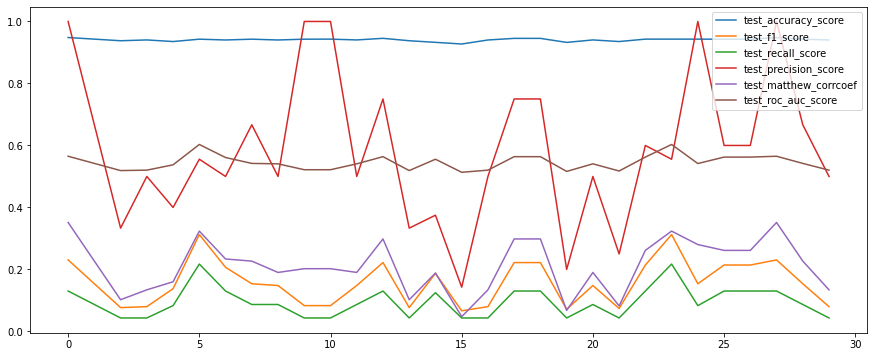

In [66]:
cv_idx =list(range(len(cv_scores['fit_time'])))

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(6)
for test_score in cv_scores.keys():
    if (test_score !='fit_time') & (test_score !='score_time'):
        plt.plot(cv_idx, cv_scores[test_score], label='{}'.format(test_score))
    
plt.legend(loc='upper right')

In graph you can see the different scores across all of the cross-validation runs. It was clear that for no single run did we achieve a score compariable to the best observed during the optimization process. This tells us the fmin function isn't optimizing the same metric we were looking at. So either we figure out how to change the metric or we come up with a different. I chose the later since reading through the documentation proved fruitless (if you know how to change the metric I would appreciate the secret).

In [67]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_optimal).ravel()
accuracy = metrics.accuracy_score(y_test, y_pred_optimal)
precision = metrics.precision_score(y_test, y_pred_optimal)
recall = metrics.recall_score(y_test, y_pred_optimal)
f1 = metrics.f1_score(y_test,y_pred_optimal)
matthew_corrcoef = metrics.matthews_corrcoef(y_test,y_pred_optimal),
roc_auc = metrics.roc_auc_score(y_test,y_pred_optimal)
avg_precision = metrics.average_precision_score(y_test, y_pred_optimal)

row3 = {'model': 'Optimized XGB-No SMOTE',
        'tp': [tp],
        'tn': [tn],
        'fp': [fp],
        'fn': [fn],
        'correct': [tp+tn],
        'incorrect': [fp+fn],
        'accuracy': [round(accuracy,3)],
        'precision': [round(precision,3)],
        'recall': [round(recall,3)],
        'f1': [round(f1,3)],
        'matthews_coef': [round(matthew_corrcoef[0],3)],
        'roc_auc': [round(roc_auc,3)],
        'avg_pre': [round(avg_precision,3)],
    }

scores3 = pd.DataFrame(row3)
print(tabulate(scores3, headers=scores3.columns))



    model                     tp    tn    fp    fn    correct    incorrect    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  ----------------------  ----  ----  ----  ----  ---------  -----------  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  Optimized XGB-No SMOTE    97  3590    34   134       3687          168       0.956         0.74      0.42  0.536            0.538      0.705      0.346


Next I checked the metrics based on the comparison of the y_test data set and the predicted results (y_pred_optimal). The y_pred_optimal should have been the last prediction from the cross-validation run and match the last entries in cv_cores. Looking below, it is clear they are not.

Need to look further into why this is happening, there is likely a random state that isn't set properly that needs to be adjusted to attain consistency.

In [68]:
for key in cv_scores.keys():
    print('key {}:score {}'.format(key,cv_scores[key][-1] ))

key fit_time:score 0.7965199947357178
key score_time:score 0.016852378845214844
key test_accuracy_score:score 0.9402597402597402
key test_f1_score:score 0.08
key test_recall_score:score 0.043478260869565216
key test_precision_score:score 0.5
key test_matthew_corrcoef:score 0.13423541509712972
key test_roc_auc_score:score 0.5203579149651693


# **PART 12:** Building, evaluating, drawing, and interpretation of final classification model

I established that hyperopt wasn't optimizing on  our desired metric, and I was unable to sort out how to change that metric. So I decided to store all parameters from the hyperopt search where the calculated roc_auc was greater than 0.7. From here the thought was, if I can get these values that are satsifying the threshold value then I can pull the parameters that generated the largest roc_auc (or whatever your desired metric is). All of these values were saved to the dictionary high_roc_scores.

In [69]:
high_roc_scores

{'Trial_model_1642465269.0170848': [{'objective': 'binary:logistic',
   'use_label_encoder': False,
   'base_score': 0.5,
   'booster': 'gbtree',
   'colsample_bylevel': 1,
   'colsample_bynode': 1,
   'colsample_bytree': 1,
   'enable_categorical': False,
   'gamma': 0.0942164121471718,
   'gpu_id': -1,
   'importance_type': None,
   'interaction_constraints': '',
   'learning_rate': 0.300000012,
   'max_delta_step': 0,
   'max_depth': 11,
   'min_child_weight': 2,
   'missing': nan,
   'monotone_constraints': '()',
   'n_estimators': 131,
   'n_jobs': 4,
   'num_parallel_tree': 1,
   'predictor': 'auto',
   'random_state': 0,
   'reg_alpha': 0,
   'reg_lambda': 6,
   'scale_pos_weight': 1,
   'subsample': 1,
   'tree_method': 'exact',
   'validate_parameters': 1,
   'verbosity': None,
   'eval_metric': 'aucpr'},
              model   tp    tn  fp   fn  accuracy  precision  recall     f1  \
  0   XGBClassifier  102  3598  26  129      0.96      0.797   0.442  0.568   
  
     matthews

In [70]:
potential_opt_params = pd.DataFrame(columns = ['gamma', 
                                              'max_depth', 
                                              'min_child_weight',
                                              'n_estimators', 
                                              'reg_alpha', 
                                              'reg_lambda',
                                              'precision',
                                              'recall',
                                              'f1',
                                              'matthews_coef',
                                              'roc_auc'])

row_idx = 0
for key in high_roc_scores.keys():
    param_dict = high_roc_scores[key]
    #print(key)
    
    temp1 = param_dict[0]
    temp2 = param_dict[1]
    for param in potential_opt_params.columns:
        if param in temp1.keys():
            potential_opt_params.at[row_idx, param] = temp1[param]
        elif param in temp2.columns:
            potential_opt_params.at[row_idx, param] = temp2[param]
    
    row_idx = row_idx + 1

    
#sort value isnt working at the moment returns the following error
# 
#The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

#potential_opt_params.sort_values('roc_auc',axis = 0,ascending=False, inplace=True)
print(tabulate(potential_opt_params, headers=potential_opt_params.columns))

        gamma    max_depth    min_child_weight    n_estimators    reg_alpha    reg_lambda    precision    recall     f1    matthews_coef    roc_auc
--  ---------  -----------  ------------------  --------------  -----------  ------------  -----------  --------  -----  ---------------  ---------
 0  0.0942164           11                   2             131            0             6        0.797     0.442  0.568            0.575      0.717
 1  0.308659            11                   2             181            0             6        0.756     0.442  0.557            0.558      0.716
 2  2.03434             11                   2             148            0             6        0.716     0.416  0.526            0.525      0.703
 3  1.16375             11                   2             189            0             6        0.754     0.424  0.543            0.546      0.708
 4  1.15424             11                   2              70            0             6        0.735     0.42 

Sorting on the desired metric (roc_auc in this case), we can grab the parameters that did generate the largest value.

In [71]:
#not sortin
potential_opt_params.iloc[0]['gamma']

0.0942164121471718

In [72]:
clf_optimal2 = XGBClassifier(
    objective= 'binary:logistic', 
    use_label_encoder= False, 
    base_score= 0.5, 
    booster= 'gbtree', 
    colsample_bylevel= 1, 
    colsample_bynode= 1, 
    colsample_bytree= 1, 
    enable_categorical= False, 
    gamma= potential_opt_params.iloc[0]['gamma'], 
    gpu_id= -1, 
    importance_type= None, 
    interaction_constraints= '', 
    learning_rate= 0.300000012, 
    max_delta_step= 0, 
    max_depth= potential_opt_params.iloc[0]['max_depth'], 
    min_child_weight= potential_opt_params.iloc[0]['min_child_weight'], 
   # missing= 'nan', 
    monotone_constraints= '()',
    n_estimators= potential_opt_params.iloc[0]['n_estimators'], 
    n_jobs= 4, 
    num_parallel_tree= 1, 
    predictor= 'auto', 
    random_state= 0, 
    reg_alpha= potential_opt_params.iloc[0]['reg_alpha'], 
    reg_lambda= potential_opt_params.iloc[0]['reg_lambda'], 
    scale_pos_weight= 1, 
    subsample= 1, 
    tree_method= 'exact', 
    validate_parameters= 1, 
    verbosity= None, 
    eval_metric= 'aucpr'
)

Now we repeat the tests from before and compare results.

In [73]:

start_time = time.time()
optimal_model2 = clf_optimal2.fit(X_train,y_train)

# set random_state = 42
#The idea was, if I have the optimal parameters, then using the same cross-validation state as during my initial testing
#should produce far better results.... it didn't   :**(

cvs = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
cv_scores2 = cross_validate(optimal_model2, X_test, y_test, cv=cvs, scoring = scorer)
y_pred_optimal2 = optimal_model2.predict(X_test)

row4 = {'model': ['Optimized XGBClassifier'],
       'run_time': [format(round((time.time() - start_time)/60,2))],
       'avg_accy': [cv_scores2['test_accuracy_score'].mean()],
       #'avg_accy_std': cv_scores2['test_accuracy_score'].std(),
       'avg_recall': [cv_scores2['test_recall_score'].mean()],
       #'avg_recall_std': cv_scores2['test_recall_score'].std(),
       'avg_precision': [cv_scores2['test_precision_score'].mean()],
       #'avg_precision_std': cv_scores2['test_precision_score'].std(),
       'avg_f1': [cv_scores2['test_f1_score'].mean()],
       #'avg_f1_std': cv_scores2['test_f1_score'].std(),
       'avg_matthew_corcoef': [cv_scores2['test_matthew_corrcoef'].mean()],
       #'avg_matthew_corcoef_std': cv_scores2['test_matthew_corrcoef'].std(),
       'avg_roc_auc':[ cv_scores2['test_roc_auc_score'].mean()],
       #'avg_roc_auc_std': cv_scores2['test_roc_auc_score'].std(),
      }
 
scores4 = pd.DataFrame(row4)
print(tabulate(scores4, headers=scores4.columns))
#df_models = df_models.append(row, ignore_index=True)

    model                      run_time    avg_accy    avg_recall    avg_precision    avg_f1    avg_matthew_corcoef    avg_roc_auc
--  -----------------------  ----------  ----------  ------------  ---------------  --------  ---------------------  -------------
 0  Optimized XGBClassifier        0.72    0.940249      0.106703         0.570863  0.173469               0.219811        0.55004


In [74]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_optimal2).ravel()
accuracy = metrics.accuracy_score(y_test, y_pred_optimal2)
precision = metrics.precision_score(y_test, y_pred_optimal2)
recall = metrics.recall_score(y_test, y_pred_optimal2)
f1 = metrics.f1_score(y_test,y_pred_optimal2)
matthew_corrcoef = metrics.matthews_corrcoef(y_test,y_pred_optimal2),
roc_auc = metrics.roc_auc_score(y_test,y_pred_optimal2)
avg_precision = metrics.average_precision_score(y_test, y_pred_optimal2)

row5 = {'model': 'Optimized XGB-No SMOTE',
        'tp': [tp],
        'tn': [tn],
        'fp': [fp],
        'fn': [fn],
        'correct': [tp+tn],
        'incorrect': [fp+fn],
        'accuracy': [round(accuracy,3)],
        'precision': [round(precision,3)],
        'recall': [round(recall,3)],
        'f1': [round(f1,3)],
        'matthews_coef': [round(matthew_corrcoef[0],3)],
        'roc_auc': [round(roc_auc,3)],
        'avg_pre': [round(avg_precision,3)],
    }

scores5 = pd.DataFrame(row3)
print(tabulate(scores5, headers=scores5.columns))

    model                     tp    tn    fp    fn    correct    incorrect    accuracy    precision    recall     f1    matthews_coef    roc_auc    avg_pre
--  ----------------------  ----  ----  ----  ----  ---------  -----------  ----------  -----------  --------  -----  ---------------  ---------  ---------
 0  Optimized XGB-No SMOTE    97  3590    34   134       3687          168       0.956         0.74      0.42  0.536            0.538      0.705      0.346


Text(0.5, 1.0, 'Precision-Recall curve:')

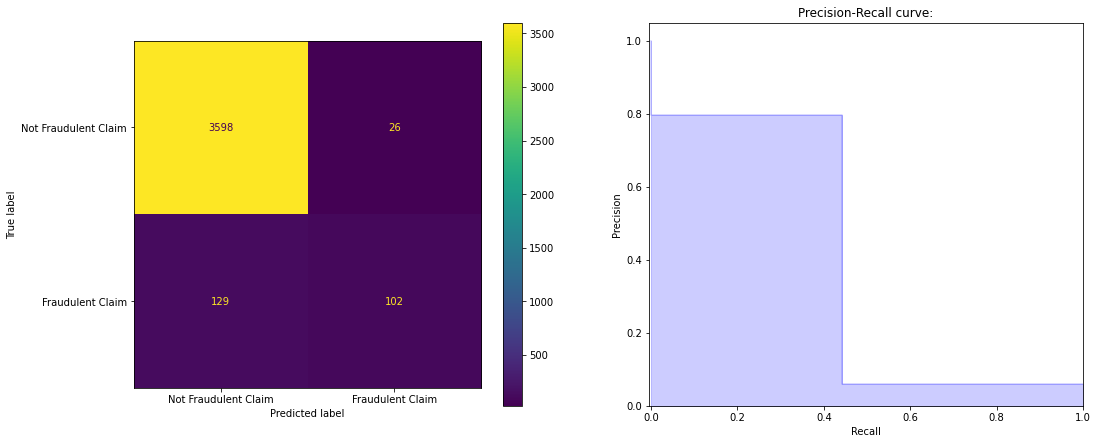

In [75]:
precision_opt2, recall_opt2, thresholds = metrics.precision_recall_curve(y_test, y_pred_optimal2)

#this code plots the confusion matrix of our niave implementation of a decision tree
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.tight_layout(pad=5.0)
metrics.plot_confusion_matrix(optimal_model2, X_test, y_test, display_labels=["Not Fraudulent Claim", "Fraudulent Claim"], ax=ax1)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_optimal2).ravel()

ax2.step(recall_opt2, precision_opt2, color='b', alpha=0.2, where='post')
ax2.fill_between(recall_opt2, precision_opt2, step='post', alpha=0.2, color='b')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_ylim([0.0, 1.05])
ax2.set_xlim([-0.005, 1.0])
ax2.set_title('Precision-Recall curve:')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

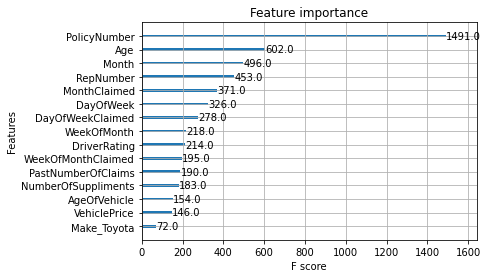

In [76]:
plot_importance(optimal_model2, max_num_features=15)



In [77]:
#fig, ax = plt.subplots(figsize=(30, 30))
#plot_tree(optimal_model, num_trees=0, ax=ax)
#plt.show()

# **References**
* Reference for hyperopt
    * http://hyperopt.github.io/hyperopt/
* Reference for XGBoost 
    * https://xgboost.readthedocs.io/en/stable/parameter.html
    * https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
    * https://machinelearningmastery.com/hyperopt-for-automated-machine-learning-with-scikit-learn/
    * https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    * https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning
    * https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
    * https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf

* References for decision trees:
    * https://scikit-learn.org/stable/modules/tree.html
    * https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
    * https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/
    * https://www.analyticsvidhya.com/blog/2015/11/easy-methods-deal-categorical-variables-predictive-modeling/?utm_source=blog&utm_medium=Categorical_data_encoding
    * https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931
  
* Selecting metrics/scoring rules for trees
    * https://practicaldatascience.co.uk/machine-learning/how-to-use-smote-for-imbalanced-classification
    * https://stats.stackexchange.com/questions/312780/why-is-accuracy-not-the-best-measure-for-assessing-classification-models
    * https://www.fharrell.com/post/class-damage/
    * https://stats.stackexchange.com/questions/91088/when-is-a-proper-scoring-rule-a-better-estimate-of-generalization-in-a-classific
    * https://contrib.scikit-learn.org/category_encoders/count.html
    * https://scikit-learn.org/stable/modules/model_evaluation.html
    
* Kaggle Notebooks I found useful
    * https://www.kaggle.com/pmarcelino/data-analysis-and-feature-extraction-with-python
    
* Using seaborn
    * https://drawingfromdata.com/seaborn/matplotlib/visualization/rotate-axis-labels-matplotlib-seaborn.html
    * https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values

* Papers
    * https://pubmed.ncbi.nlm.nih.gov/28574989/